# Third Assignment on Applied Machine Learning
## Greek Parliament Proceedings

On this Jupyter Notebook we will investigate the Greek Parliament Proceedings from 1989 to 2019.
The dataset we will use is available in <https://zenodo.org/record/2587904>.

The attributes of our dataset are:

**member_name**: The official name of the parliament member that talked during a sitting.

**sitting_date**: The date that the sitting took place. There are cases were more than one sittings took place at the same date.

**parliamentary_period**: The name and/or number of the parliamentary period that the speech took place in. A parliamentary period includes multiple parliamentary sessions.

**parliamentary_session**: The name and/or number of the parliamentary session that the speech took place in. A parliamentary session includes multiple parliamentary sittings.

**parliamentary_sitting**: The name and/or number of the parliamentary sitting that the speech took place in.

**political_party**: The political party that the speaker belongs to.

**speaker_info**: Information about the speaker extracted from the text of the proceeding/sitting record that refers to the parliamentary role of the speaker such as Chairman of the Parliament, Finance Minister or similar.

**speech**: The speech that the member made during the sitting of the Greek Parliament.

___
<font color=blue>
Dimitris Giannopoulos, Senior Student | 8170019
<br>
Athens University of Economics & Business
<br>
Department of Management of Science & Technology
<br>
t8170019@aueb.gr
</font>

___
* On the first section of the notebook we will try to predict the Political Party of  the speaker based on his/her speech.

*The Results for non-NN classification can be found [here](#mlclass)*


* On the second section of the notebook, we will try to predict the same thing by using Neural Network.

*The Results for NN classification can be found [here](#nnclass)*

____
**The are some hashtags/comments inside the notebook. In order to run this notebook you may have to remove them.**

**Some Classifiers and Grid Searches were done in a Cloud called [Saturn Cloud](https://www.saturncloud.io/s/). So, we turned the parameter `n_jobs` to -1, to get the full advantage of the Cloud. You may need to remove this parameter in order to run it properly.**

**The Neural Networks trained on Google's Colab TPU. I have modified, so it can run on any other hardware.**

In [1]:
#You have yo remove the hashtags if spacy isn't installed on yout computer

#!pip install spacy
#!pip install spacy --upgrade
#!python -m spacy download el_core_news_md

     |████████████████████████████████| 12.8MB 6.1MB/s 
     |████████████████████████████████| 460kB 59.1MB/s 
     |████████████████████████████████| 1.1MB 62.3MB/s 
     |████████████████████████████████| 9.2MB 62.0MB/s 
     |████████████████████████████████| 122kB 58.3MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=8bfc7aa85c812f1aa65e6f4b4bab39f751cb7faba9aaa598b25698813c9b26fc
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for smart-open: filename=smart_open-3.0.0-cp36-none-any.whl size=107097 sha256=14eecaae3bc44e18e5dd377344477d1ed67be8729c86c44b589a0b49f37212cb
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built contextvars smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Suc

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import unicodedata as ud

* First of all, we need to read our dataset. <br>
*Before reading out dataset, we will change an option on pandas to increase the columns' widths. We do these because the last column is a speech and it may contain a very long text.*

In [3]:
%%time
link = 'https://zenodo.org/record/2587904/files/Greek_Parliament_Proceedings_1989_2019.csv.zip'
pd.set_option('max_colwidth', 200)
greek_df = pd.read_csv(link, parse_dates=['sitting_date'])
greek_df

CPU times: user 33.8 s, sys: 3.2 s, total: 37 s
Wall time: 1min 11s


## Cleaning & Preprocessing

* Firstly, we will check for any NaN values on our columns.

In [4]:
greek_df.isna().sum()

member_name               47289
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party             162
speaker_info             543871
speech                       10
dtype: int64

* We see that there are some NaNs in *member_name, political_party, speaker_info and speech.*
* We will drop any NaN in `speech` feature.

In [5]:
greek_df = greek_df.loc[~greek_df['speech'].isna()]

* We will try to find out some of the missing values in politcal_party.
* We will do this by finding the member's name and the assigning the political_party based on the internet.
* We will begin by finding any row with `political_party` = NaN and `member_name` is NaN. If we can't find either the name or the political party, then we will drop it.

In [6]:
greek_df = greek_df.loc[ ~(greek_df['member_name'].isna() & greek_df['political_party'].isna())]

* We see that, from 162 missing values, we have only 38 missing values.
* We will try to fill those values by checking their `member_name` value.

In [7]:
greek_df.loc[greek_df.political_party.isna()]['member_name'].value_counts()

νακος σταυρου αθανασιος  / κολλια-τσαρουχα ευστρατιου μαρια / γρηγορακος γεωργιου λεωνιδας / μαρκογιαννακης εμμανουηλ χρηστος             4
βενιζελος κυριακου νικητας                                                                                                                4
σουρλας ιωαννη γεωργιος / χατζηγακης μιχαηλ σωτηριος / τραγακης παναγιωτη ιωαννης                                                         3
κοσιωνης ανδρεα παναγιωτης                                                                                                                2
σουρλας ιωαννη γεωργιος / τραγακης παναγιωτη ιωαννης                                                                                      2
χαραλαμπιδου δημητριου δεσποινα                                                                                                           2
νακος σταυρου αθανασιος  / τραγακης παναγιωτη ιωαννης / κολλια-τσαρουχα ευστρατιου μαρια / δραγασακης ανδρεα ιωαννης                      2
δρεττακης γεωργιου ε

* We see that there are some values in `member_name` feature consist of more than one person.
* We can't fill those values, because they don't have one political_party.
* We can find the *βενιζελος κυριακου νικητας, κοσιωνης ανδρεα παναγιωτης, χαραλαμπιδου δημητριου δεσποινα, δρεττακης γεωργιου εμμανουηλ, γεωργιαδης νικολαου μαριος, δραγασακης ανδρεα ιωαννης, κρητικος νικολαου παναγιωτης,νικολαιδου αρισταρχου βαρβαρα (βερα), τζαννετακης πετρου τζαννης*
* We will use a simple for to find the political parties from our data. Then we insert those values to the missing  ones.

In [8]:
list_of_members = ['βενιζελος κυριακου νικητας', 'κοσιωνης ανδρεα παναγιωτης',
                   'χαραλαμπιδου δημητριου δεσποινα', 'δρεττακης γεωργιου εμμανουηλ',
                   'γεωργιαδης νικολαου μαριος', 'δραγασακης ανδρεα ιωαννης',
                   'κρητικος νικολαου παναγιωτης','νικολαιδου αρισταρχου βαρβαρα (βερα)',
                   'τζαννετακης πετρου τζαννης']
list_pp = []

for member in list_of_members:
    pp = greek_df.loc[greek_df.member_name == member].political_party.iloc[0]
    list_pp.append(pp)
    print(pp)

πολιτικη ανοιξη
συνασπισμος της αριστερας των κινηματων και της οικολογιας
συνασπισμος ριζοσπαστικης αριστερας
συνασπισμος της αριστερας των κινηματων και της οικολογιας
ενωση κεντρωων
συνασπισμος της αριστερας των κινηματων και της οικολογιας
πανελληνιο σοσιαλιστικο κινημα
κομμουνιστικο κομμα ελλαδας
νεα δημοκρατια


* Now we will assign those political parties to the right members.

In [9]:
greek_df.loc[ greek_df.member_name == 'βενιζελος κυριακου νικητας', 'political_party'] = 'πολιτικη ανοιξη'
greek_df.loc[ greek_df.member_name == 'κοσιωνης ανδρεα παναγιωτης', 'political_party'] = 'συνασπισμος της αριστερας των κινηματων και της οικολογιας'
greek_df.loc[ greek_df.member_name == 'χαραλαμπιδου δημητριου δεσποινα', 'political_party'] = 'συνασπισμος ριζοσπαστικης αριστερας'
greek_df.loc[ greek_df.member_name == 'δρεττακης γεωργιου εμμανουηλ', 'political_party'] = 'συνασπισμος της αριστερας των κινηματων και της οικολογιας'
greek_df.loc[ greek_df.member_name == 'γεωργιαδης νικολαου μαριος', 'political_party'] = 'ενωση κεντρωων'
greek_df.loc[ greek_df.member_name == 'δραγασακης ανδρεα ιωαννης', 'political_party'] = 'συνασπισμος της αριστερας των κινηματων και της οικολογιας'
greek_df.loc[ greek_df.member_name == 'κρητικος νικολαου παναγιωτης', 'political_party'] = 'πανελληνιο σοσιαλιστικο κινημα'
greek_df.loc[ greek_df.member_name == 'νικολαιδου αρισταρχου βαρβαρα (βερα)', 'political_party'] = 'κομμουνιστικο κομμα ελλαδας'
greek_df.loc[ greek_df.member_name == 'τζαννετακης πετρου τζαννης', 'political_party'] = 'νεα δημοκρατια'

* Now we can drop any rows where political party is empty.

In [10]:
greek_df = greek_df.dropna(subset=['political_party'])

* Let's check again the NaNs in our dataframe.

In [11]:
greek_df.isna().sum()

member_name               47165
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party               0
speaker_info             543867
speech                        0
dtype: int64

* We will drop the rows with `speaker_info = προεδρευων` or `speaker_info = προεδρος`, because *προεδρος and προεδρευων* means President in Greek and is the President of the Hellenic Parliament.
* The President of the Greek Hellenic Parliament is chosen by a vote during the opening session, after each legislative election. When he/she becomes President, he/she stops acting as an MP of a party, that is, with an ideologically charged discourse, but he has only a coordinating role and acts neutrally towards everyone. Find more [here](https://en.wikipedia.org/wiki/Speaker_of_the_Hellenic_Parliament).

In [12]:
greek_df = greek_df.loc[ ~((greek_df.speaker_info == 'προεδρευων') | (greek_df.speaker_info == 'προεδρος'))]
greek_df.speaker_info.value_counts(dropna=False)

NaN                                                 543867
βουλευτης/ες                                         47165
υφυπουργος οικονομικων                                7201
υπουργος δικαιοσυνης                                  5882
υφυπουργος εθνικης παιδειας και θρησκευματων          4367
                                                     ...  
υπουργος εθνικης αμυνας και υπουργος δικαιοσυνης         1
υπουργος υποδομων και δικτυων                            1
υπουργος εθνικης οικονομιας και οικονομιας               1
υπουργος υγειας, προνοιας κοινωνικων, ασφαλισεων         1
υπουργο δικαιοσυνης                                      1
Name: speaker_info, Length: 1270, dtype: int64

* Now we will check the `member_name`.

In [13]:
greek_df.loc[greek_df.member_name.isna()]

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
10,NaN,1989-07-04,period 5,session 1,sitting 2,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
18,NaN,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,βουλευτης/ες,Να μας τη διαβάσετε.
59,NaN,1989-07-05,period 5,session 1,sitting 3,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
61,NaN,1989-07-05,period 5,session 1,sitting 3,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
...,...,...,...,...,...,...,...,...
1194086,NaN,2019-02-21,period 17 presided parliamentary republic,session 4,sitting 81,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
1194096,NaN,2019-02-21,period 17 presided parliamentary republic,session 4,sitting 81,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
1194338,NaN,2019-02-21,period 17 presided parliamentary republic,session 4,sitting 81,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
1194340,NaN,2019-02-21,period 17 presided parliamentary republic,session 4,sitting 81,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."


* We see that there are many rows with `member_name` = NaN and `political_party` = βουλη.
* `βουλη` means parliament in greek, so it isn't a political party, but all politicians together.
* We will drop those rows.

In [14]:
greek_df = greek_df.loc[ ~((greek_df.member_name.isna()) & (greek_df.political_party == 'βουλη'))]
print(greek_df.isna().sum(), '\n', greek_df.shape)

member_name                1289
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party               0
speaker_info             543867
speech                        0
dtype: int64 
 (735771, 8)


* Let's now find more about the political parties.

In [15]:
greek_df.political_party.value_counts()

νεα δημοκρατια                                                                     232974
πανελληνιο σοσιαλιστικο κινημα                                                     226942
συνασπισμος ριζοσπαστικης αριστερας                                                 80455
κομμουνιστικο κομμα ελλαδας                                                         60894
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          26123
ανεξαρτητοι (εκτος κομματος)                                                        24259
λαικος ορθοδοξος συναγερμος                                                         17310
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     15402
λαικος συνδεσος - χρυση αυγη                                                        14172
ενωση κεντρωων                                                                       6649
δημοκρατικο κοινωνικο κινημα                                                         6056
το ποταμι 

* We will use the short name for its political party. (e.g νεα δημοκρατιια -> ΝΔ, κομμουνιστικο κομμα ελλαδας -> ΚΚΕ κλπ)
* First, we will make a dictionary with the full and short names. 
* Then, we will create a mapping function, to alter the names.

In [16]:
poli_dict = {
    'νεα δημοκρατια' : 'ΝΔ',
    'πανελληνιο σοσιαλιστικο κινημα' : 'ΠΑΣΟΚ',
    'συνασπισμος ριζοσπαστικης αριστερας' : 'ΣΥΡΙΖΑ',
    'κομμουνιστικο κομμα ελλαδας' : 'ΚΚΕ',
    'συνασπισμος της αριστερας των κινηματων και της οικολογιας' : 'ΣΥΝΑΣΠΙΣΜΟΣ',
    'ανεξαρτητοι (εκτος κομματος)': 'ανεξαρτητοι',
    'λαικος ορθοδοξος συναγερμος' : 'ΛΑΟΣ',
    'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)' : 'ΔΗ.ΣΥ',
    'λαικος συνδεσος - χρυση αυγη' : 'Χ.Α.',
    'ανεξαρτητοι ελληνες - πανος καμμενος' : 'ΑΝ.ΕΛ',
    'ενωση κεντρωων' : 'Ε.Κ.',
    'το ποταμι' : 'ΠΟΤΑΜΙ',
    'δημοκρατικο κοινωνικο κινημα' : 'ΔΗΚΚΙ',
    'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια' : 'Α.Ε.Ε.Π.ΔΣ',
    'δημοκρατικη αριστερα' : 'ΔΗΜΑΡ',
    'πολιτικη ανοιξη' : 'ΠΟΛ.ΑΝ', 
    'ανεξαρτητοι δημοκρατικοι βουλευτες' : 'Α.Δ.Β',
    'λαικη ενοτητα' : 'ΛΕ',    
    'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)' : 'Ο.Ε.',
    'κομμουνιστικο κομμα ελλαδας εσωτερικου' : 'ΚΚΕ(εσ)',
    'αντιπολιτευση'  : 'αντιπολιτευση',                                                            
    'δημοκρατικη ανανεωση' : 'ΔΗΑΝΑ'                                                  
}
pol_f = lambda x: poli_dict.get(x, x) 
greek_df.loc[:, 'political_party'] = greek_df.loc[:, 'political_party'].map(pol_f)

greek_df.political_party.value_counts(normalize=True)*100

ΝΔ               31.663928
ΠΑΣΟΚ            30.844108
ΣΥΡΙΖΑ           10.934788
ΚΚΕ               8.276216
ΣΥΝΑΣΠΙΣΜΟΣ       3.550425
ανεξαρτητοι       3.297086
ΛΑΟΣ              2.352634
ΔΗ.ΣΥ             2.093314
Χ.Α.              1.926143
Ε.Κ.              0.903678
ΔΗΚΚΙ             0.823082
ΠΟΤΑΜΙ            0.813161
ΑΝ.ΕΛ             0.730390
Α.Ε.Ε.Π.ΔΣ        0.576674
ΔΗΜΑΡ             0.571373
ΠΟΛ.ΑΝ            0.284056
Α.Δ.Β             0.240428
ΛΕ                0.047026
Ο.Ε.              0.041725
ΚΚΕ(εσ)           0.027454
αντιπολιτευση     0.001495
ΔΗΑΝΑ             0.000815
Name: political_party, dtype: float64

* We will drop any **political party** with less than 1%. (ΛΕ, Ο.Ε. , ΚΚΕ(εσ), αντιπολιτευση, ΔΗΑΝΑ.
* Also, we need to drop the political party with name `ανεξαρτητοι`. Those are politicians, who were part of a political party, but they left and they became independent.

In [17]:
dropped_pp = ['Ε.Κ.', 'ΠΟΤΑΜΙ', 'ΔΗΚΚΙ', 'Α.Ε.Ε.Π.ΔΣ',
              'ΔΗΜΑΡ', 'ΠΟΛ.ΑΝ', 'Α.Δ.Β', 'ΛΕ', 'Ο.Ε.', 'ΚΚΕ(εσ)', 'αντιπολιτευση', 'ΔΗΑΝΑ']
greek_df = greek_df[~greek_df.political_party.isin(dropped_pp)]
greek_df.shape

(703905, 8)

* Also, we need to make several changes on the political parties.
* Based on [wikipedia](https://en.wikipedia.org/wiki/Synaspismos) and [in.gr article](https://www.in.gr/2004/01/08/greece/synaspismos-rizospastikis-aristeras-i-eklogiki-synergasia-toy-syn-me-alles-dynameis/) `ΣΥΝΑΣΠΙΣΜΟΣ` was the largest party of the left-wing coalition formed in 2004 called `ΣΥΡΙΖΑ` and it,finally, dissolved in 2013. So, we will replace rows with political party = `ΣΥΝΑΣΠΙΣΜΟΣ`, after 2004, with `ΣΥΡΙΖΑ`.
* Before we do this, we will create 4 new columns which will be day, month, year and weekday.

In [18]:
greek_df['day'] = greek_df.sitting_date.apply(lambda x: x.day)
greek_df['month'] = greek_df.sitting_date.apply(lambda x: x.month)
greek_df['year'] = greek_df.sitting_date.apply(lambda x: x.year)
greek_df['weekday'] = greek_df.sitting_date.dt.day_name()
greek_df['day'].astype(str)
greek_df['month'].astype(str)
greek_df['year'].astype(str)
greek_df.drop(columns=['sitting_date'])
greek_df.shape

(703905, 12)

In [19]:
greek_df.loc[ ((greek_df['political_party'] == 'ΣΥΝΑΣΠΙΣΜΟΣ') & (greek_df['year'] >= 2004)), 'political_party'] = 'ΣΥΡΙΖΑ'

## Visualisation & Descriptives

### Speeches per Political Party
* Let's visualize the speeches per political party.

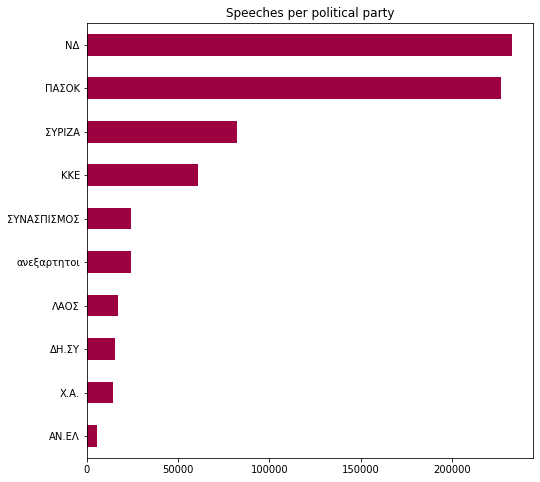

In [20]:
greek_df.political_party.value_counts().sort_values(ascending=True).\
        plot(kind='barh', colormap='Spectral', figsize=(8,8), title='Speeches per political party')

### Speeches over time
* Let's find the speeches over time.

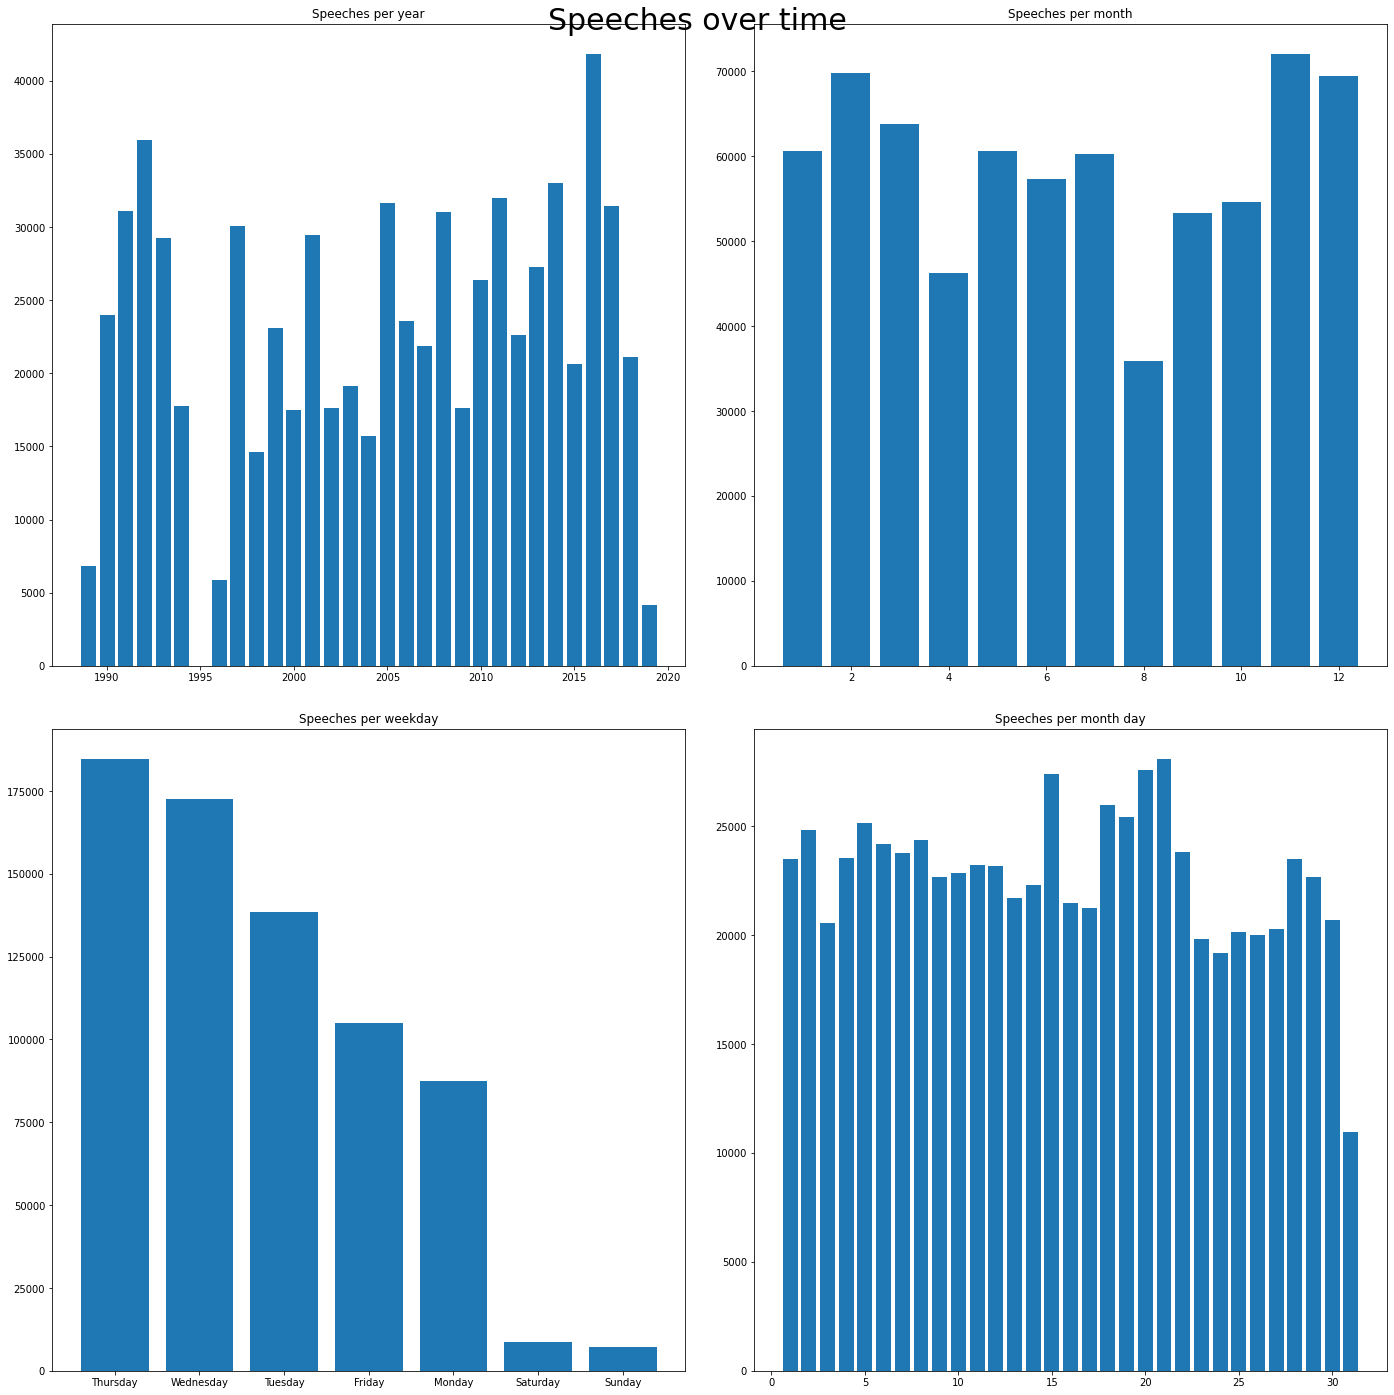

In [21]:
figure, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,20))

figure.suptitle('Speeches over time', fontsize=30)
axes[0, 0].title.set_text('Speeches per year')
axes[0, 0].bar(greek_df.year.value_counts().index, greek_df.year.value_counts())

axes[0, 1].title.set_text('Speeches per month')
axes[0, 1].bar(greek_df.month.value_counts().index, greek_df.month.value_counts())

axes[1, 0].title.set_text('Speeches per weekday')
axes[1, 0].bar(greek_df.weekday.value_counts().index, greek_df.weekday.value_counts())

axes[1, 1].title.set_text('Speeches per month day')
axes[1, 1].bar(greek_df.day.value_counts().index, greek_df.day.value_counts())

figure.tight_layout(pad=3.0)

* We see that every one or two years, there is an increase on speeches. The year with most speeches is *2016*.
* Also, about speeches per month, there is a decrease on *August* and *April*. We can say that the most hot seasons are *winter* and *autumn*.
* As for weekdays it is clear that during the weekends there aren't a lot of speeches. The days with the most speeches are *Tuesday* and *Wednesday*.

### Speeches per political party over time
* Let's continue by analyzing our data by political parties.
* First of all let's create again all the above plots, but this time we will add the *political party* dimension.

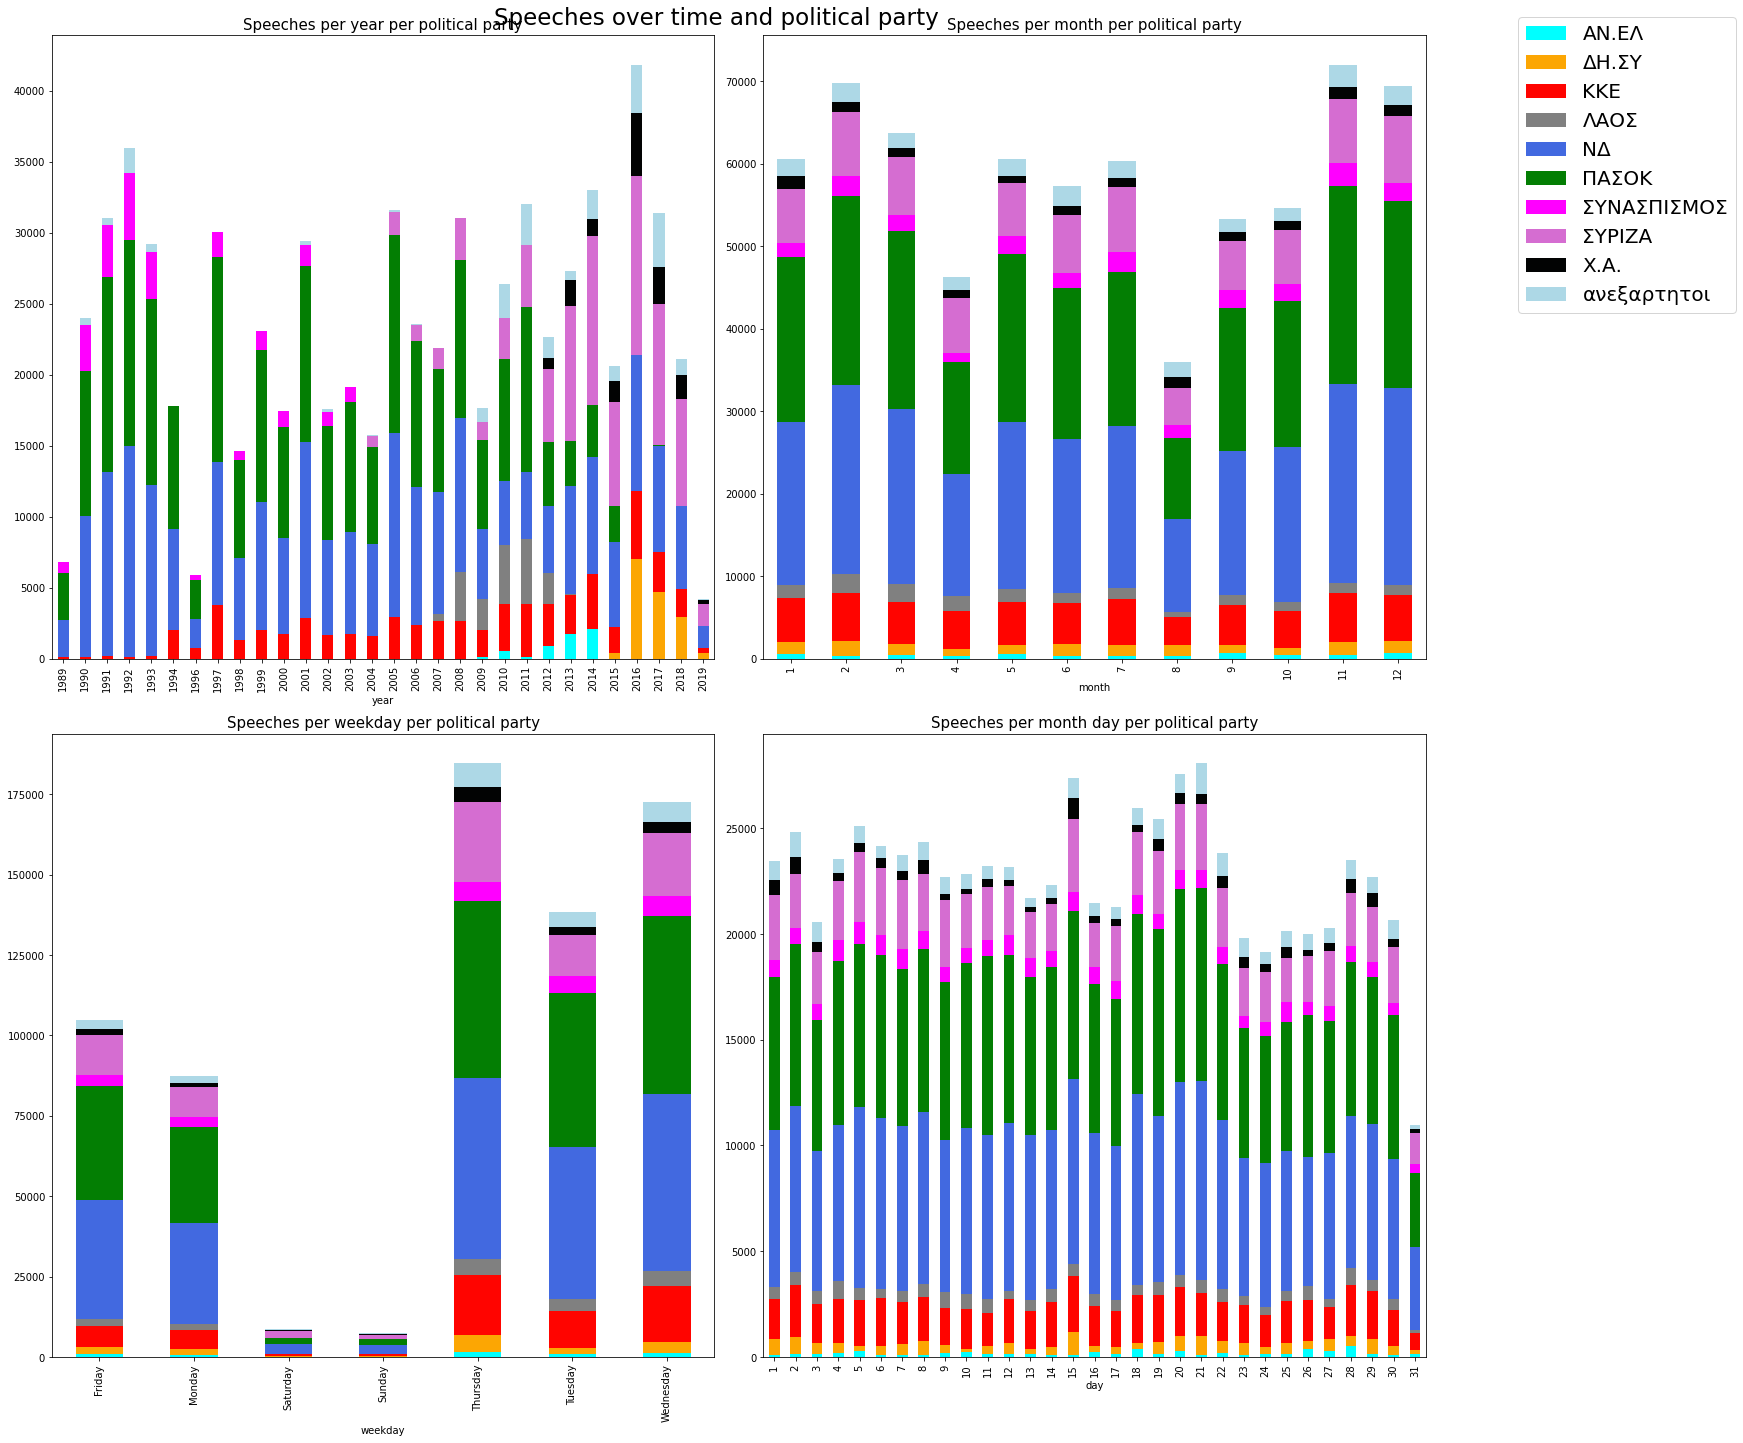

In [22]:
#assigned colors to the political parties alphabetically
colors = [ 'cyan', 'orange', 'red', 'grey', 'royalblue', 'green', 'magenta', 'orchid','black', 'lightblue']
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)


figure1, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

figure1.suptitle('Speeches over time and political party',y=1, fontsize=23)

axes[0, 0].set_title('Speeches per year per political party',
                          fontdict ={'fontsize': 15 })
group1 = greek_df.groupby(['year','political_party']).size().unstack().\
                    plot(kind='bar', stacked=True, colormap=cmap1, ax=axes[0,0], legend=False)


axes[0, 1].set_title('Speeches per month per political party',
                          fontdict ={'fontsize': 15 })
greek_df.groupby(['month','political_party']).size().unstack().\
                    plot(kind='bar', stacked=True, colormap=cmap1, ax=axes[0,1], legend=False)


axes[1, 0].set_title('Speeches per weekday per political party',
                         fontdict ={'fontsize': 15 })
greek_df.groupby(['weekday','political_party']).size().unstack().\
                    plot(kind='bar', stacked=True, colormap=cmap1, ax=axes[1,0], legend=False)


axes[1, 1].set_title('Speeches per month day per political party',
                         fontdict ={'fontsize': 15 })
greek_df.groupby(['day','political_party']).size().unstack().\
                    plot(kind='bar', stacked=True, colormap=cmap1, ax=axes[1,1], legend=False)

figure1.tight_layout()
handles, labels = axes[1,1].get_legend_handles_labels()
plt.legend( handles, labels,bbox_to_anchor=(1.05, 1), loc='upper left',
            bbox_transform = plt.gcf().transFigure, prop={'size': 20})

* On the first bar plot *Speeches per year per political party*, we can see the parties in power during the years. 
  * 1989 - 1993: power party was **ΝΔ (blue)** and second party was **ΠΑΣΟΚ (green)**.
  * 1989 - 2003: power party was **ΠΑΣΟΚ (green)** and second party was **ΝΔ (blue)**.
  * 2004 - 2008: power party was **ΝΔ (blue)** and second party was **ΠΑΣΟΚ (green)**.
  * 2009 - 2012: power party was **ΠΑΣΟΚ (green)** and second party was **ΝΔ (blue)**.
  * 2009 - 2012: power party was **ΝΔ (blue)** and second party was **ΣΥΡΙΖΑ (orchid)**.
  * 2015 - 2018: power party was **ΣΥΡΙΖΑ (orchid)** and second party was **ΝΔ (blue)**.
  * 2019 - now : power party is **ΝΔ (blue)** and secnd party is **ΣΥΡΙΖΑ (orchid)**.

* We can not draw any other conclusions, from the rest graphs.

### Spekers per Political Party
* Let's now explore our data with an extra dimension, the member name (speaker).

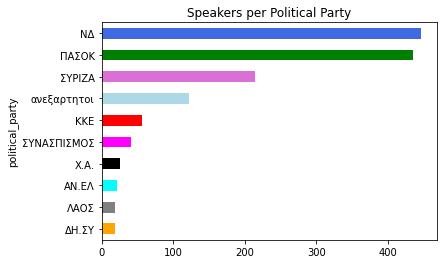

In [23]:
colors1 = ['orange', 'grey', 'cyan', 'black', 'magenta', 'red', 'lightblue', 'orchid', 'green', 'royalblue']
greek_df.groupby(['political_party'])['member_name'].nunique().sort_values(ascending=True).\
                                                    plot(kind='barh', color=colors1, title='Speakers per Political Party')

* The political parties with the most speakers are obviously the ones which have been in power, *ΝΔ, ΠΑΣΟΚ and ΣΥΡΙΖΑ*. 

### Average words per Political Party, PP member and Sitting time 
<a id="words"></a>
* Now we will work on the `speech` column. 
* First, we will count the words per speech. We won't make any changes now, we just want to take a glance on this column because later we will do a classification on it.

In [24]:
greek_df['words_p_s'] = [len(x.split()) for x in greek_df['speech'].tolist()]

* We will find *Average words per speech per political party, Average words per year per political party, the top 50 most talkative politicians and the Top 20 dates based on mean words per speech.*

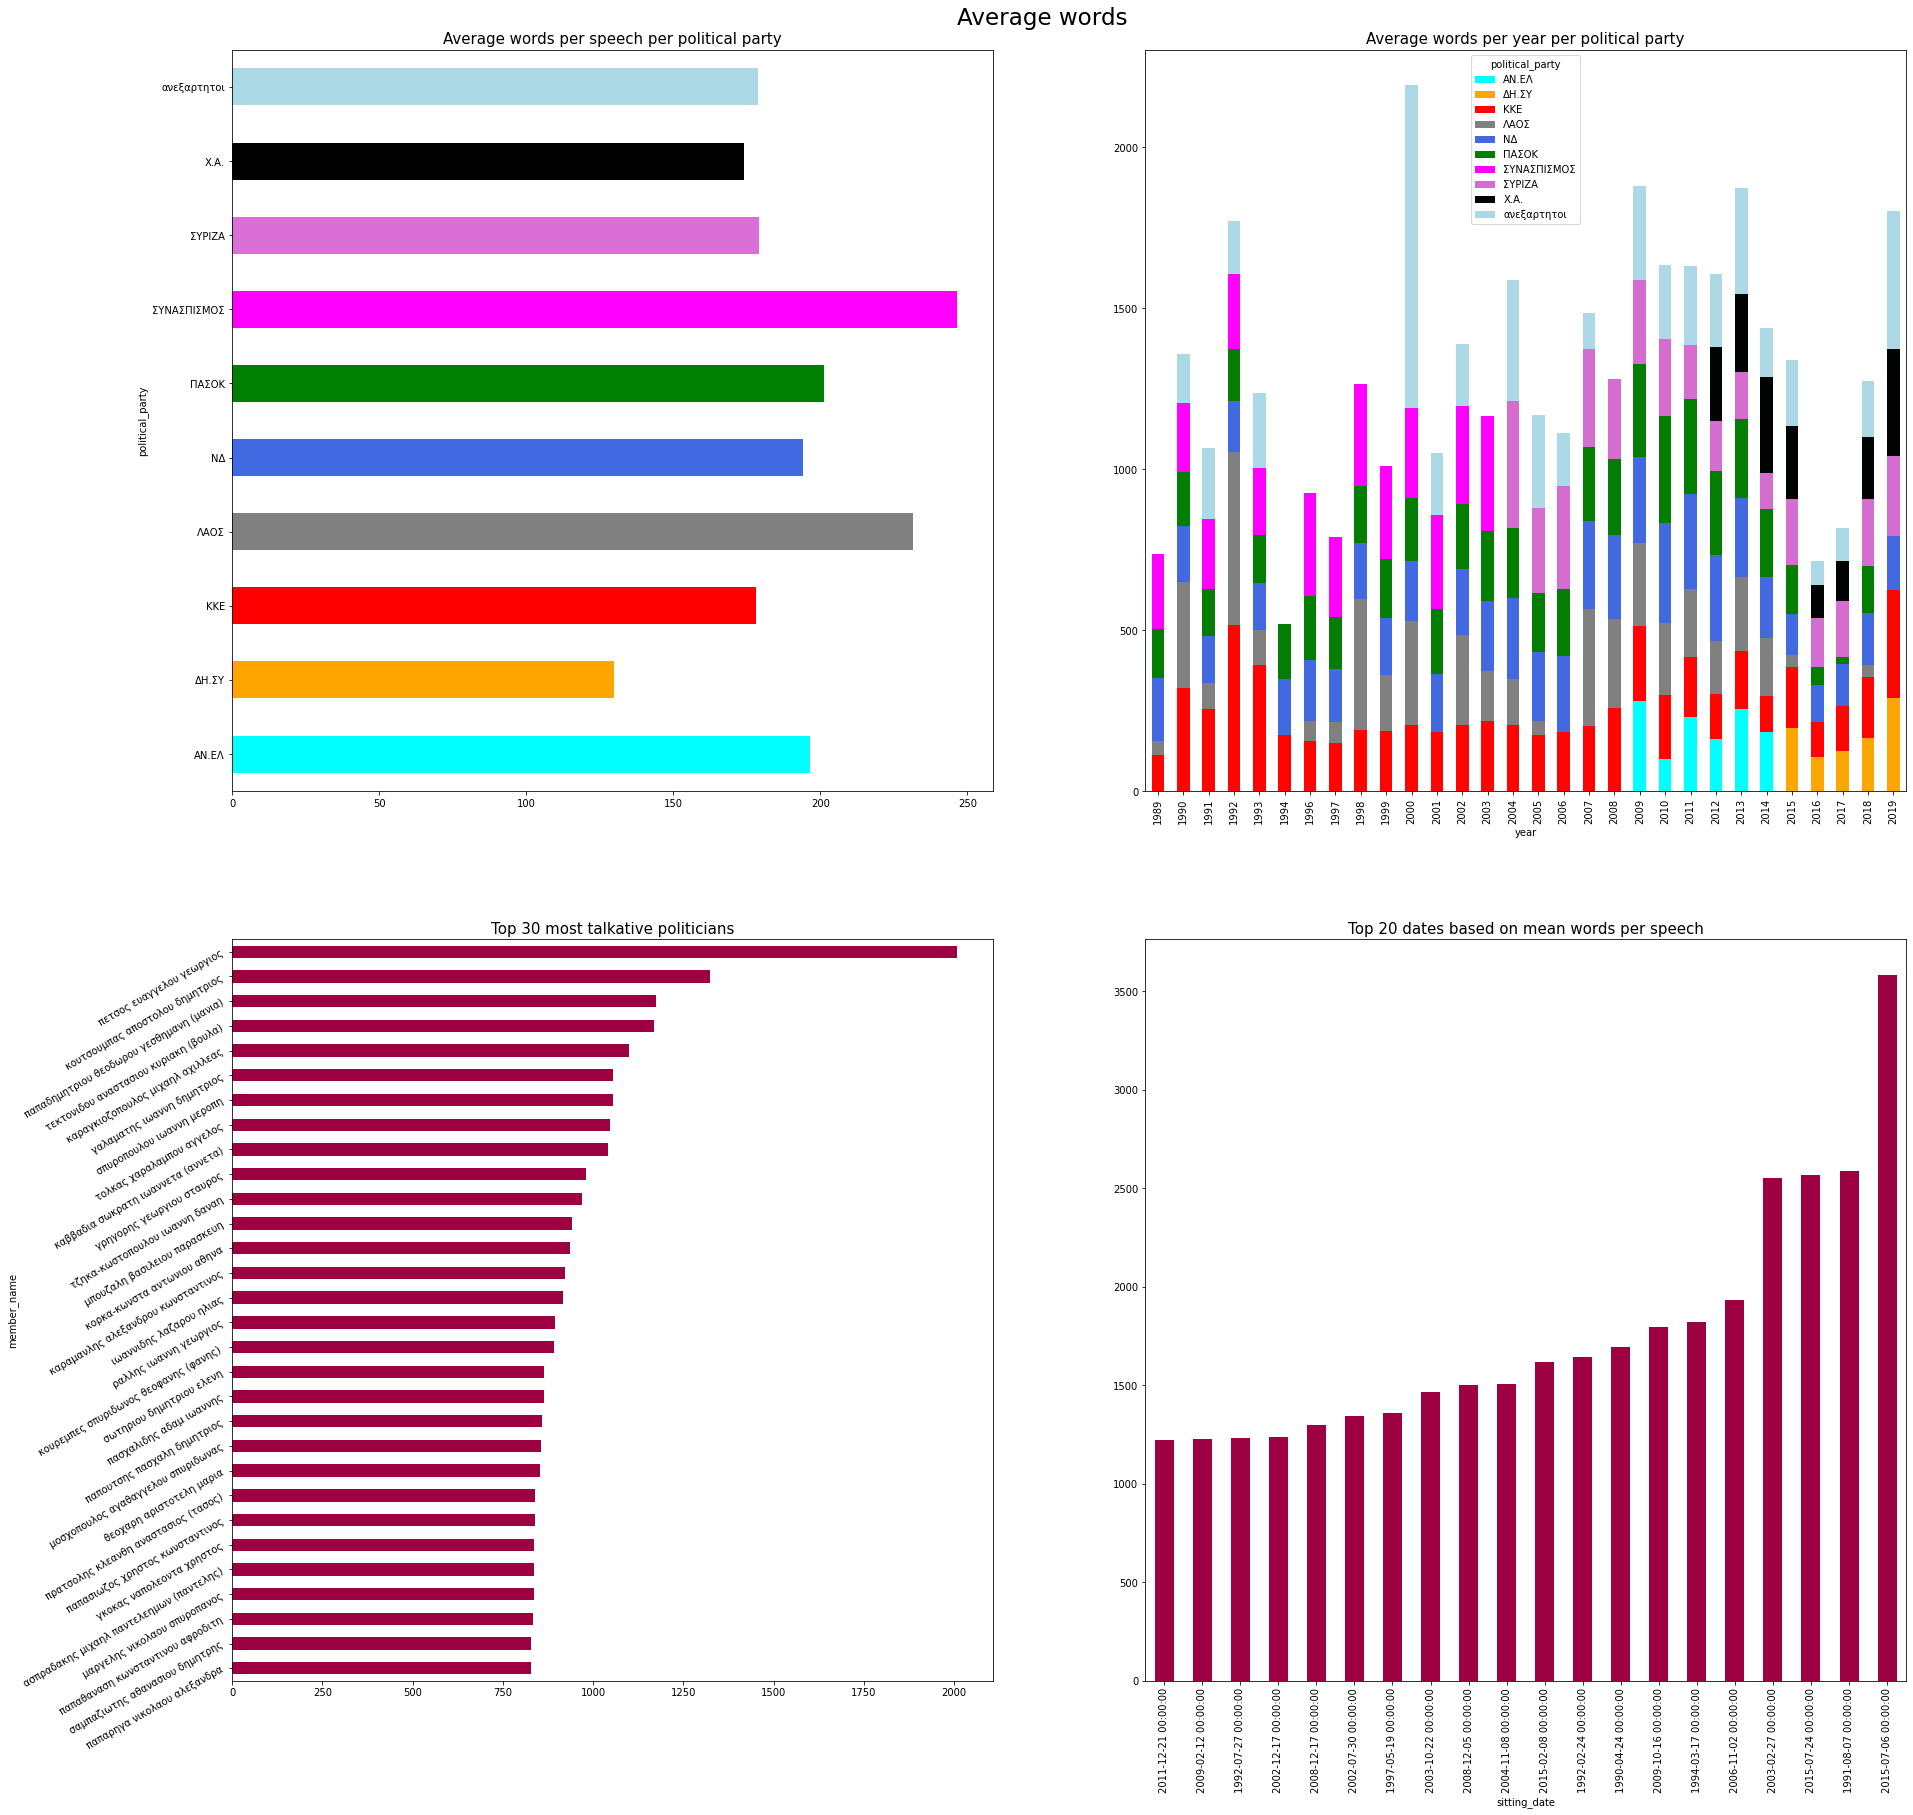

In [25]:
figure1, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,30))

colors2 = ['cyan', 'orange', 'red', 'grey', 'royalblue', 'green', 'magenta', 'orchid', 'black', 'lightblue']
#colors2 = ['magenta', 'grey', 'green', 'cyan', 'royalblue', 'orchid', 'lightblue', 'red', 'black', 'orange']

figure1.suptitle('Average words',y=0.9, fontsize=23)

axes[0, 0].set_title('Average words per speech per political party',
                          fontdict ={'fontsize': 15 })
greek_df.groupby('political_party')['words_p_s'].mean()\
                                                 .plot(kind='barh', color=colors2, ax=axes[0,0])

axes[0, 1].set_title('Average words per year per political party',
                          fontdict ={'fontsize': 15 })
greek_df.groupby(['year','political_party'])['words_p_s'].mean().unstack()\
                                                 .plot(kind='bar', stacked=True, ax=axes[0,1], colormap=cmap1)

axes[1, 0].set_title('Top 30 most talkative politicians',
                          fontdict ={'fontsize': 15 })
greek_df.groupby('member_name')['words_p_s'].mean().nlargest(30).sort_values(ascending=True)\
                                                 .plot(kind='barh', ax=axes[1,0], rot=30,  colormap='Spectral')


axes[1, 1].set_title("Top 20 dates based on mean words per speech",
                          fontdict ={'fontsize': 15 })
greek_df.groupby('sitting_date')['words_p_s'].mean().nlargest(20).sort_values(ascending=True)\
                                                 .plot(kind='bar', ax=axes[1,1], colormap='Spectral')

* We see that the most talkative political parties are *ΛΑΟΣ, ΣΥΝΑΣΠΙΣΜΟΣ and Χ.Α.*. For ΛΑΟΣ and Χ.Α. it is predictable, because they are far-right parties. 
* Also, about Average words per year per political party, we understand that, the party with most words per year is *ανεξαρτητοι*. *ανεξαρτητοι* means independent in greek, so it is not a political party but many independent members who are not affiliated with any political party.
* As for the most talkative members, the first place belongs to *πετσας ευαγγελου γεωργιου*. It is extraordinary that our dataset begins on the last year of his political career. His last 2 speeches, on 1989, were about the bomb attack that he was under from *the Revolutionary Organization 17th November*, because he was involved in one of the biggest scandals in Greece, *Koskotas Corruption Scandal*. You can learn more on [*Koskotas Corruption Scandal*](https://en.wikipedia.org/wiki/George_Koskotas) and [*17N attack on May 8, 19898*](https://apnews.com/article/8f197a72a675f7767f1cfd54f8998479).

# Machine Learning

* Now we will preprocess the dataset, to run several classifiers.
* Firstly, we need to choose a subset of our dataset because of our infrastracture. The subset needs to have the **8 different political parties**. 
* Also, it needs to be balanced. By balanced, we mean that each party must have approximately the same amount of **data** (*speeches*).


For the above reasons, we will keep the data from *2004 to 2019*. During this period, **7** parliamentary elections were held and the Government changed *3* times. We will also keep speeches by the political party `Συνασπισμός` because this party appeared before the selected period.
After a lot of consideration, we chose to remove the political party called `ανεξαρτητοι`. As mentioned before, `ανεξαρτητοι` means independents in Greek. It is not a specific political party, but it consists of politicians who left a party they belonged to. Also, we will remove the political party `ΑΝ.ΕΛ` because we found out that we have very little data about it.

In [26]:
greek_df_cl = greek_df.loc[ (greek_df.sitting_date.dt.year >= 2004) | (greek_df.political_party == 'ΣΥΝΑΣΠΙΣΜΟΣ') ]
greek_df_cl = greek_df_cl.loc [((greek_df_cl.political_party != 'ανεξαρτητοι')) ]
greek_df_cl = greek_df_cl.loc [~(greek_df_cl['political_party'] == 'ΑΝ.ΕΛ') ]
greek_df_cl = greek_df_cl.reset_index(drop=True)
greek_df_cl.shape

(400657, 13)

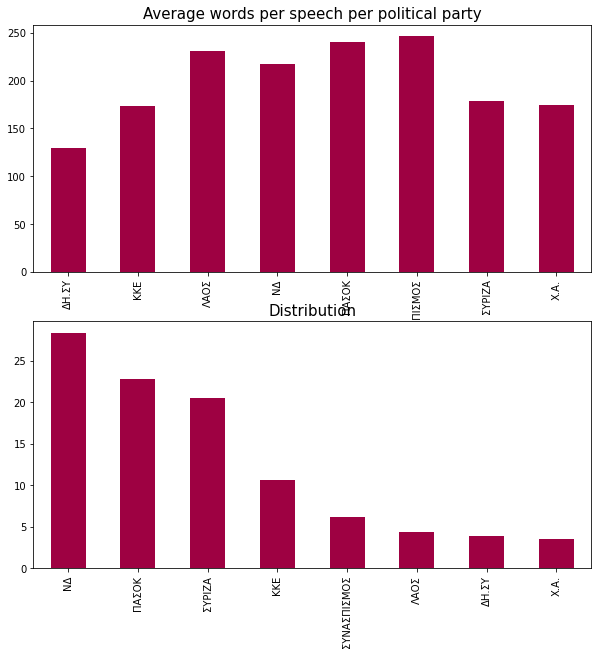

In [27]:
figure2, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))


figure1.suptitle('Classification dataset',y=0.9, fontsize=23)

axes[0].set_title('Average words per speech per political party',
                          fontdict ={'fontsize': 15 })
greek_df_cl.groupby('political_party')['words_p_s'].mean()\
                                                 .plot(kind='bar', ax=axes[0], colormap='Spectral')

axes[1].set_title('Distribution',
                          fontdict ={'fontsize': 15 })
(greek_df_cl.political_party.value_counts(normalize=True)*100)\
                                                 .plot(kind='bar', ax=axes[1], colormap='Spectral')                                                

## Preprocessing

* Now we can drop any unwanted columns. 
* We will keep only `speech` and `political party`.

In [28]:
greek_df_cl = greek_df_cl[['speech', 'political_party']].copy()

* Also, we will give a number to each political party, because classification models can't work with text.
* We will use *LabelEncoder()* from sklearn library.

In [29]:
from sklearn import preprocessing

leb = preprocessing.LabelEncoder()
leb.fit(greek_df_cl['political_party'])
greek_df_cl['political_party'] = leb.transform(greek_df_cl['political_party'])
greek_df_cl['political_party'].value_counts()

3    113552
4     91179
6     82114
1     42511
5     24464
2     17263
0     15402
7     14172
Name: political_party, dtype: int64

* Now we have to clean the speech column.
* Let's print some samples in order to find some features we don't really need.

In [30]:
pd.set_option('max_colwidth', None)
greek_df_cl.speech.str.split('\n')[:20]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

As for the words:
* We will use spaCy's greek stop words, to find any words that are very common in Greek language.
* We use `el_core_news_sm` because it has the same stop_words as `el_core_news_lg`.
* The list with the stop words are diacritical marks, so with pass it through the normalizer to remove them.

In [31]:
import spacy
from spacy.lang.el.stop_words import STOP_WORDS
import re
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

all_stopwords = STOP_WORDS
all_stopwords2 = []
for word in all_stopwords:
   x = ud.normalize('NFD',word).translate(d)
   all_stopwords2.append(x)
len(all_stopwords2)

663

As for the text:
* We need to replace the **numbers** with hashtags.
* Next we will remove any **extra whitespaces**.
* Lastly, we remove any **accents/diacritics** and we **lower-casing** its character.

In [32]:
%%time

greek_df_cl.speech = greek_df_cl.speech.apply(lambda x: re.sub(r'\d+','#',x) )   #replacing numbers with hashtags
greek_df_cl.speech = greek_df_cl.speech.apply(lambda x: re.sub(r'[^\w\s]',' ',x) ) #removing punctuations
greek_df_cl.speech = greek_df_cl.speech.apply(lambda x: " ".join(x.split()) )     #removing extra whitespaces
greek_df_cl.speech = greek_df_cl.speech.apply(lambda x: ud.normalize('NFD',x).lower().translate(d)) #removing diacritics and lowering


CPU times: user 1min 30s, sys: 2.11 s, total: 1min 32s
Wall time: 1min 32s


* Before proceeding with classification etc., we will split our data to `training` and `testing` data. We split the dataset to *67% train* and *33% test* and we *shuffle* our data.
* For **X_train** we use the column *speech* and for **y_train** we use the column *political_party*.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(greek_df_cl.speech.values, greek_df_cl.political_party.values, test_size=0.33, random_state=42, shuffle = True)

* Also, we will use the spacy's tokenizer.
* We disable components we don’t need.

In [34]:
nlp = spacy.load("el_core_news_md", disable=['ner', 'parser', 'tagger'])

def spacy_tokenizer(doc):
    return [x.orth_ for x in nlp.tokenizer(doc)]

# Classification without Neural Networks
<a id="mlclass"></a>
* For the Supervised ML, we tried several approaches. Specifically, we tried 2 Naive Bayes Classifiers, 1 Linear and 1 Tree Approach. All Classifiers are from sklearn library. Also, we ran several optimizations for the Classifiers.
* To gauge the efficacy of the different algorithms, we ran the scikit-learn's DummyClassifier.
___
**Results**

|Classifier    | Accuracy | Precision| Recall | F-1 score  |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| ----| ----| (macro| (macro) | (macro) |
| Dummy      | 19%       |13% |13%|13%|
| **Naive Bayes Approach** |
| Multinomial NB    | 32%       |59%|15%|11%|
|Multinomial NB *(tuned)* |44%|64%|28%|28%|
|Multinomial NB *(balanced)*|38%|34%|37%|33%|
|Complement NB| 36%|35%|42%|34%|
| **Linear Approach** |
| LinearSVC *(tuned)*    | **47%**       |**45%**|**42%**|**42%**|
| LinearSVC *(C=0.3)*  |**47%**|**45%**|**43%**|**42%**|
|LinearSVC *(balanced)*|46%|42%|43%|42%|
|Logistic Regression *(tuned)*| 47%|47%|41%|40%|
| **Tree Approach** |
| Random Forest *(100 trees)*    | 39%       |40%|25%|25%|
| XGB Classifier *(balanced)* |40%|62%|27%|29%|

* So, the best approach was the linear with the Linear SVC, it gave 47% accuracy with F-1 score 42%, which means that it had the less missclassified data.








### Dummy Classifier
* Firstly, we will make a *Dummy Classifier*, to compare are Classifiers.
* We use the *sklearn's* **CountVectorizer** and **TfidfTransformer**.
* We also use our own tokenizer and we set ngram_range = (1,2) and we pass as stop_words the list we had made.
* Also, we set verbose to True, to print the time for each step in Pipeline. This will help us to decide if we need to use *HashingVectorizer*, over *CountVectorizer*.

In [ ]:
%%time
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline

dummy_clf = Pipeline([('vect', CountVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer()),
                     ('dummy', DummyClassifier(strategy="stratified", random_state = 5)),
                    ], verbose=True)

dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(metrics.classification_report(y_test, dummy_pred,
                                    target_names=leb.classes_))

[Pipeline] .............. (step 1 of 3) Processing vect, total= 4.5min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  12.1s
[Pipeline] ............. (step 3 of 3) Processing dummy, total=   0.0s
              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.04      0.04      0.04      5176
         ΚΚΕ       0.11      0.11      0.11     14139
        ΛΑΟΣ       0.04      0.04      0.04      5741
          ΝΔ       0.29      0.29      0.29     37422
       ΠΑΣΟΚ       0.23      0.23      0.23     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.06      0.06      0.06      7980
      ΣΥΡΙΖΑ       0.21      0.21      0.21     26924
        Χ.Α.       0.03      0.03      0.03      4752

    accuracy                           0.19    132217
   macro avg       0.13      0.13      0.13    132217
weighted avg       0.19      0.19      0.19    132217

CPU times: user 6min 19s, sys: 3.96 s, total: 6min 23s
Wall time: 6min 24s


### Naive Bayes Approach
#### MultinomialMB
* The first Classifier we will use is the Multinomial Naive Bayes.

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics

multi_pip = Pipeline([('vect', CountVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ], verbose = True)

multi_pip.fit(X_train, y_train)

multi_pip_pred = multi_pip.predict(X_test)
print(metrics.classification_report(y_test, multi_pip_pred,
                                    target_names=leb.classes_))

[Pipeline] .............. (step 1 of 3) Processing vect, total= 5.2min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  19.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.9s
              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.00      0.00      0.00      5176
         ΚΚΕ       0.84      0.00      0.01     14139
        ΛΑΟΣ       1.00      0.00      0.00      5741
          ΝΔ       0.32      0.94      0.48     37422
       ΠΑΣΟΚ       0.47      0.11      0.18     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       1.00      0.00      0.01      7980
      ΣΥΡΙΖΑ       0.28      0.16      0.20     26924
        Χ.Α.       0.80      0.00      0.00      4752

    accuracy                           0.32    132217
   macro avg       0.59      0.15      0.11    132217
weighted avg       0.48      0.32      0.22    132217

CPU times: user 7min 8s, sys: 11.2 s, total: 7min 20s
Wall time: 7min 20s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


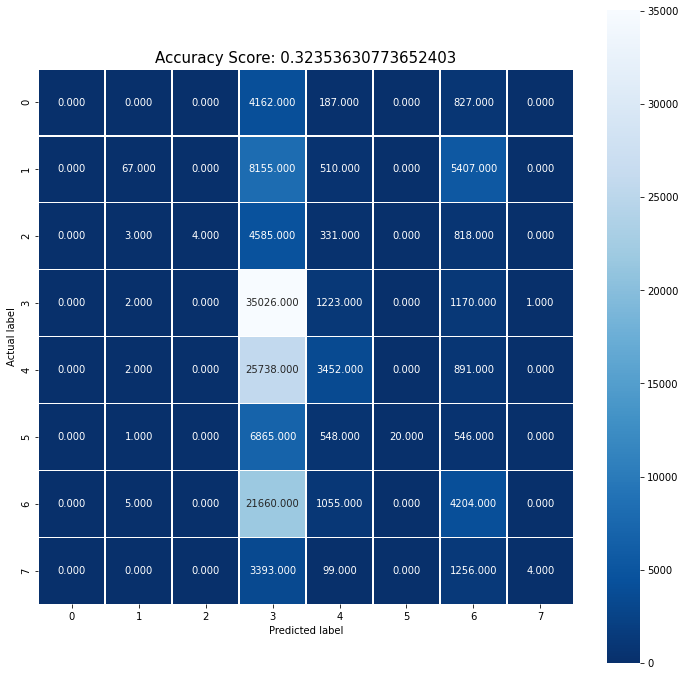

In [ ]:
cm = metrics.confusion_matrix(y_test, multi_pip_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(multi_pip.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

* **Multinomial Naive Bayes** gives *32%* accuracy, which is better than Dummy Classifier. Though, we see that some political parties aren't predicted. Maybe this model is underfit.
* So, we will try to optimize the Pipeline by tunning hyper-parameters on Pipeline.

##### Trying HashingVectorizer
* As we saw, in MultinomialNB, the CountVectorizer took around 5.5 minutes, so we will use **HashingVectorizer** from *sklearn library*. 
* We pass the same *hyperparameters* and we disable **alternative_sign**, because the MultinomialNB classifier won't work with negative values.

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics

multi_pip_h = Pipeline([('vect', HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2), alternate_sign=False)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ], verbose = True)

multi_pip_h.fit(X_train, y_train)

multi_pip_h_pred = multi_pip_h.predict(X_test)
print(metrics.classification_report(y_test, multi_pip_h_pred,
                                    target_names=leb.classes_))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 2.0min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   9.9s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.6s
              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.00      0.00      0.00      5176
         ΚΚΕ       0.45      0.33      0.38     14139
        ΛΑΟΣ       0.86      0.00      0.00      5741
          ΝΔ       0.34      0.91      0.49     37422
       ΠΑΣΟΚ       0.47      0.22      0.30     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.93      0.00      0.01      7980
      ΣΥΡΙΖΑ       0.39      0.09      0.14     26924
        Χ.Α.       0.80      0.00      0.00      4752

    accuracy                           0.36    132217
   macro avg       0.53      0.19      0.17    132217
weighted avg       0.45      0.36      0.28    132217

CPU times: user 3min 11s, sys: 1.38 s, total: 3min 13s
Wall time: 3min 13s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* We see that accuracy is around *36%* but some political parties (classes) weren't predicted. 
* Altough, accuracy is higher than Dummy's, recalls and precisions are still low or 0.
* We will print the confusion matrix to have a better view on our model.

**Printing confusion matrix**
* We see that the most classes are being predected as **Class 3 - ΝΔ**.
* This can mean that the Classifier is *underfitted.*

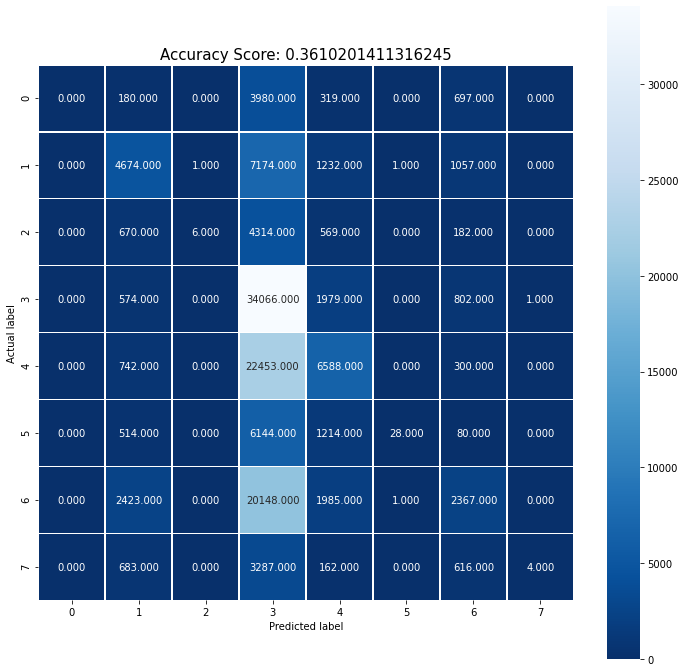

In [ ]:
cm = metrics.confusion_matrix(y_test, multi_pip_h_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(multi_pip_h.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

##### Tuning hyper-parameters.

* We use the **GridSearchCV** from sklearn to tune the hyper-parameters.
* The hyper-parameters we will search are:
  * [*MultinomialMB*](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomial#sklearn.naive_bayes.MultinomialNB):
    * `alpha`, is a smoothing parameter. We will try to find the optimum number for alpha. We will use **GridSearchCV** from sklearn. We will set the alpha = *10e-9 or 0.1 or 0.2 or 0.5 or 1*. Note that 10e-9 is equivalent to 0 and is the smallest price that alpha can get.

* For score, we use the F-1 metric, because we saw on the previous model that accuracy, precision and recall aren't very accurate. So, we will get a combination of precision and recall. Also, we utilise *macro* because are model is a multi-class classifier.

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline


multi_pip_h = Pipeline([('vect', HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2), alternate_sign=False)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ], verbose=True)

grid_values = { 'clf__alpha' : [10e-9, 0.1, 0.2, 0.5, 1]}

multi_pip_grid = GridSearchCV(multi_pip_h, param_grid = grid_values, scoring='f1_macro')

multi_pip_grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.9s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.9s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.9s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.4s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.8s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.9s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.4s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.5s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.8s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.8s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.8s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  22.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.8s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  21.6s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[Pipeline] .............. (step 1 of 3) Processing vect, total= 2.0min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=  27.6s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.4s
CPU times: user 1h 4min 17s, sys: 6.93 s, total: 1h 4min 24s
Wall time: 1h 4min 29s


* Getting the best alpha.
* It seems that `alpha = 0.1` is the best

In [ ]:
multi_pip_grid.best_params_

{'clf__alpha': 0.1}

* Predicting with the best model.
* We see that the accuracy is around *44 %*, but we succed a higher precisions and recalls for each party. Also, some parties that on the first model didn't gor any prediction, now they are predicted. F-1 score is suprisingly high, compering to the first score.

In [ ]:
multi_pip_grid_pred = multi_pip_grid.predict(X_test)
print(metrics.classification_report(y_test, multi_pip_grid_pred,
                                    target_names=leb.classes_))

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.70      0.00      0.01      5176
         ΚΚΕ       0.49      0.55      0.52     14139
        ΛΑΟΣ       0.85      0.05      0.10      5741
          ΝΔ       0.41      0.73      0.52     37422
       ΠΑΣΟΚ       0.45      0.44      0.44     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.89      0.12      0.22      7980
      ΣΥΡΙΖΑ       0.45      0.29      0.36     26924
        Χ.Α.       0.88      0.05      0.10      4752

    accuracy                           0.44    132217
   macro avg       0.64      0.28      0.28    132217
weighted avg       0.51      0.44      0.40    132217



**Printing the confusion matrix**

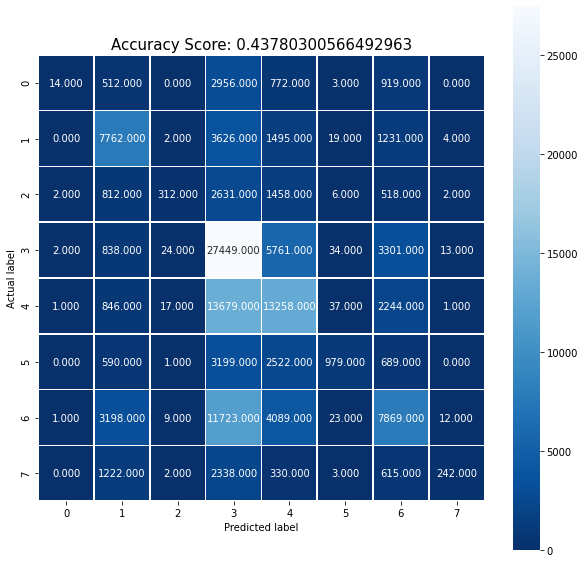

In [ ]:
cm = metrics.confusion_matrix(y_test, multi_pip_h_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(multi_pip_grid.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

#### Dealing with imbalanced data.
* Another thing we can do to optimise our model is try to balanced our data.
* We will use the the *SMOTE Technique* to over sample the minor classes and *RandomUnderSampler* to under sample the major classes.
* First, we need to check the amount for each class we have on the training data.

In [ ]:
print("Frequency of each class in training data:")
print(np.asarray((np.unique(y_train, return_counts=True))))

Frequency of each class in training data:
[[    0     1     2     3     4     5     6     7]
 [10226 28372 11522 76130 61096 16484 55190  9420]]


* Now we can see wich classes are minorities and which are majorities.
* We will try to tune the amounts, we don't want to be all classes on the same amount of data.
* We will try all minorities to have around 15,000 data and majorities around 25,000 data.
* For this technique, we will use the imblearn's *Pipeline*.

In [ ]:
%%time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline


pipeline_imb = Pipeline([('vect', HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2), alternate_sign=False)),        
                     ('oversampling', SMOTE()),
                     ('undersampling', RandomUnderSampler()),
                     ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB(alpha = 0.1)),
                     ], verbose=True)

pipeline_imb.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 12min 12s, sys: 7.12 s, total: 12min 19s
Wall time: 12min 19s


* Printing the classification report.
* We see that the *SMOTE* and *RandomUnderSampler* really help.
* Although, accuracy got lower, macro avg of precision, recall and f1-score got higher. This means that its class is better predicted.

In [ ]:
pred_pipeline_imb = pipeline_imb.predict(X_test)
from sklearn import metrics
print(metrics.classification_report(y_test, pred_pipeline_imb,
                                    target_names=leb.classes_))

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.11      0.43      0.18      5176
         ΚΚΕ       0.46      0.54      0.50     14139
        ΛΑΟΣ       0.14      0.21      0.17      5741
          ΝΔ       0.52      0.44      0.48     37422
       ΠΑΣΟΚ       0.49      0.39      0.44     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.29      0.37      0.33      7980
      ΣΥΡΙΖΑ       0.50      0.26      0.34     26924
        Χ.Α.       0.18      0.28      0.22      4752

    accuracy                           0.38    132217
   macro avg       0.34      0.37      0.33    132217
weighted avg       0.45      0.38      0.40    132217



* Printing the **confusion matrix**.
* We see that most of data are being predicted on the right class. The problem is with the classes *2, 5 and 7 (ΛΑΟΣ, ΣΥΝΑΣΠΙΣΜΟΣ, Χ.Α.)*

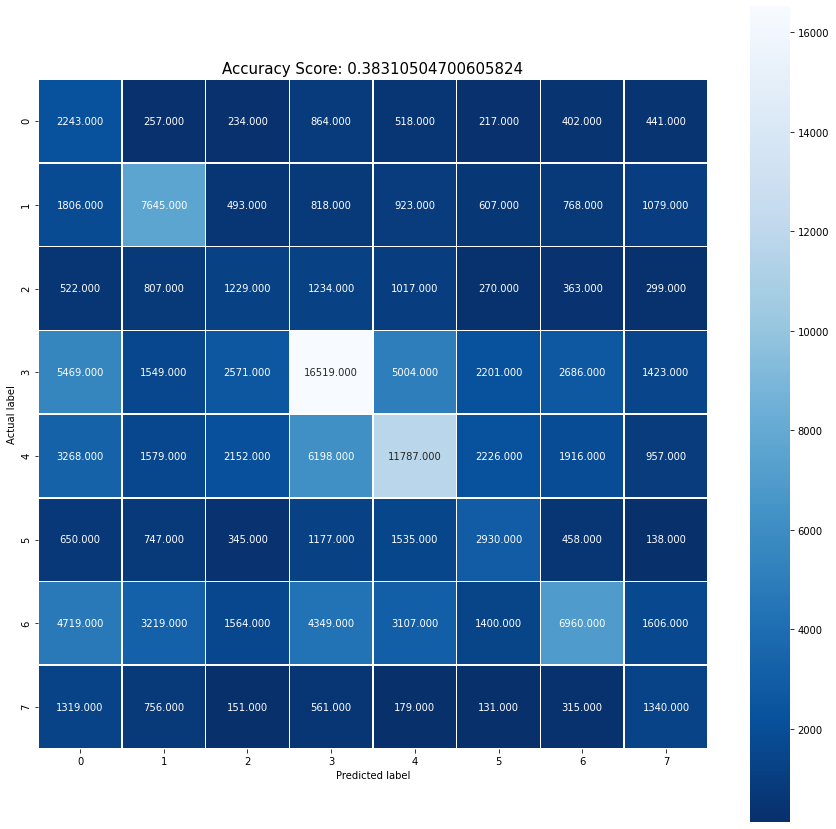

In [ ]:
cm = metrics.confusion_matrix(y_test, pred_pipeline_imb)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(pipeline_imb.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

#### ComplementNB
* Another Classifier we can use is the ComplementNB.
* Based on sklearn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB), it is particularly suited for imbalanced data sets.

In [ ]:
%%time
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from imblearn.pipeline import Pipeline
from sklearn import metrics

comple_pip_h = Pipeline([('vect', HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2), alternate_sign=False)),        
                     ('oversampling', SMOTE()),
                     ('undersampling', RandomUnderSampler()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', ComplementNB(alpha=0.1)),
                    ], verbose = True)

comple_pip_h.fit(X_train, y_train)

comple_pip_h_pred = comple_pip_h.predict(X_test)
print(metrics.classification_report(y_test, comple_pip_h_pred,
                                    target_names=leb.classes_))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.13      0.51      0.21      5176
         ΚΚΕ       0.45      0.57      0.50     14139
        ΛΑΟΣ       0.17      0.41      0.24      5741
          ΝΔ       0.57      0.34      0.42     37422
       ΠΑΣΟΚ       0.51      0.35      0.42     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.27      0.60      0.37      7980
      ΣΥΡΙΖΑ       0.53      0.19      0.28     26924
        Χ.Α.       0.19      0.39      0.25      4752

    accuracy                           0.36    132217
   macro avg       0.35      0.42      0.34    132217
weighted avg       0.47      0.36      0.38    132217

CPU times: user 13min 5s, sys: 4.62 s, total: 13min 10s
Wall time: 13min 9s


* We can see that the accuracy is around 36%. 
* We didn't really get a better recalls and precisions. Though there is an increase for the minority.

**Printing confusion matrix**


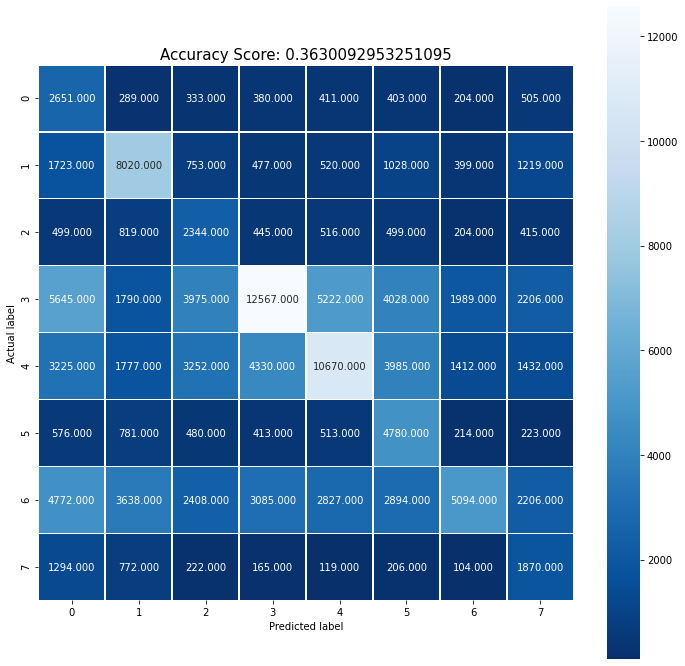

In [ ]:
cm = metrics.confusion_matrix(y_test, comple_pip_h_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(comple_pip_h.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

#### Cross Validating the best model of Naive Bayes.
* We will use the sklearn's **StratifiedKFold**
* We apply 10 folds and we are searching for the F-1 score.
* We see that the F-1 macro is 0.33 with a standard deviation of 0.00.
* This means that the best our model can get is 0.33 f-1 score.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from imblearn.pipeline import Pipeline
from sklearn import metrics

comple_pip_h = Pipeline([('vect', HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2), alternate_sign=False)),        
                     ('oversampling', SMOTE()),
                     ('undersampling', RandomUnderSampler()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', ComplementNB(alpha=0.1)),
                    ], verbose = True)


stra_cv = StratifiedKFold(n_splits=10, random_state=5)

scores = cross_val_score(comple_pip_h, X_train, y_train, cv = stra_cv, scoring='f1_macro')
print(scores)
print()
print("%0.2f F-1 score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=

[0.32957246 0.33191935 0.33314544 0.33024936 0.33331758 0.33177798
 0.3277301  0.34009835 0.32906481 0.33098137]

0.33 F-1 score with a standard deviation of 0.00


###  Linear Approach
### Linear Support Vector Classifier
* The next classiifer we will use is the linear SVC.
* We use the Linear and not the classic Support Vector Classifier, because based on the **sklearn** librady it supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.
* Firstly, as we saw before the dataset is stronlgy imbalanced. So, we will try to make some weights for its class.

* The equation we will use is a basic equation based on sklearn's compute_sample_weight package:

'$$w_i = \cfrac{\sum(p_i)}{p_iN} \\w_1\text{: weight of class} \text{ , } p_1\text{: quantity of class}$$


In [ ]:
class_weights = {}
total = len(y_train)
for i in range(0,8):

  population_i = np.bincount(y_train)[i]
  class_weights[i] = (1/population_i) * (total)/8
print(class_weights)

{0: 3.281341678075494, 1: 1.1826801071478923, 2: 2.9122548168720708, 3: 0.4407592276369368, 4: 0.5492176247217494, 5: 2.035610288764863, 6: 0.6079905780032615}


* We will use again the **GridSearchCV** to find those hyper parameters that maximaze the classification.
* As we did before we will use F-1 score as scoring parameter, because our dataset is imbalanced. 
* The hyper parameters we will use is the ** C, class weight, penalty and tol**.
* Based on sklearn *C, penalty and tol* are those that can make any difference on the model. Also, with *class_weight* we find out if the class weights we just made are making any difference.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.pipeline import make_pipeline
from sklearn import metrics


grid_values = { 'C' : [0.1, 0.5, 1],
                'class_weight' : ['balanced', class_weights, None],
                'penalty' : ['l1', 'l2'], 
                'tol' : [1e-4, 0.1, 0.2]
              }

stra_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)


lscv_pip = make_pipeline(HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2)),
                         TfidfTransformer(),
                         GridSearchCV(LinearSVC(random_state = 5),
                                                    param_grid = grid_values, n_jobs = -1, verbose = 3,
                                                    cv = stra_cv, scoring = 'f1_macro',
                                                    refit = True))

* We fit the model.

In [ ]:
%%time
lscv_pip.fit(X_train, y_train)

/srv/conda/envs/saturn/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 15.5min finished


CPU times: user 2min 41s, sys: 3.03 s, total: 2min 44s
Wall time: 18min 11s


Pipeline(steps=[('hashingvectorizer',
                 HashingVectorizer(ngram_range=(1, 2),
                                   stop_words=['τοσου', 'καμποσες', 'ολα',
                                               'ορισμενων', 'ορισμενα',
                                               'εκαστος', 'μελλεται', 'καθενος',
                                               'οταν', 'αλλοι', 'προχτες',
                                               'εξι', 'προχθες', 'οσων',
                                               'καθολου', 'εχομε', 'περι',
                                               'αλλιωτικα', 'καμποσης', 'γι',
                                               'εαυτους', 'τοσην', 'ποιος',
                                               'του', 'οποιου', 'ετερους',
                                               'ενα', 'λιγο', 'καμιας', 'κανεν', ...]...
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                              estimator=Linear

* Printing the best hyper parameters.
  * *C = 0.5*
  * *We should use the weights we made.*
  * *penalty = l2*
  * *tol = 0.1*

In [ ]:
lscv_pip[2].best_params_

{'C': 0.5,
 'class_weight': {0: 3.281341678075494,
  1: 1.1826801071478923,
  2: 2.9122548168720708,
  3: 0.4407592276369368,
  4: 0.5492176247217494,
  5: 2.035610288764863,
  6: 0.6079905780032615},
 'penalty': 'l2',
 'tol': 0.1}

In [ ]:
lscv_pip_pred = lscv_pip.predict(X_test)
print(metrics.classification_report(y_test, lscv_pip_pred,
                                    target_names=leb.classes_))

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.18      0.26      0.21      5176
         ΚΚΕ       0.46      0.65      0.54     14139
        ΛΑΟΣ       0.37      0.36      0.36      5741
          ΝΔ       0.50      0.56      0.53     37422
       ΠΑΣΟΚ       0.54      0.46      0.49     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.41      0.55      0.47      7980
      ΣΥΡΙΖΑ       0.50      0.37      0.42     26924
        Χ.Α.       0.64      0.19      0.30      4752

    accuracy                           0.47    132217
   macro avg       0.45      0.42      0.42    132217
weighted avg       0.49      0.47      0.47    132217



* The results are suprisingly good. The accuracy went up to 47%.
* Also, recalls and precisions are high.

* **Printing the confusion matrix**
* We see that the diagonal is a little bit lighter, which means that we have a good precision on the classes.
* Though, the problem with the majority class remains.

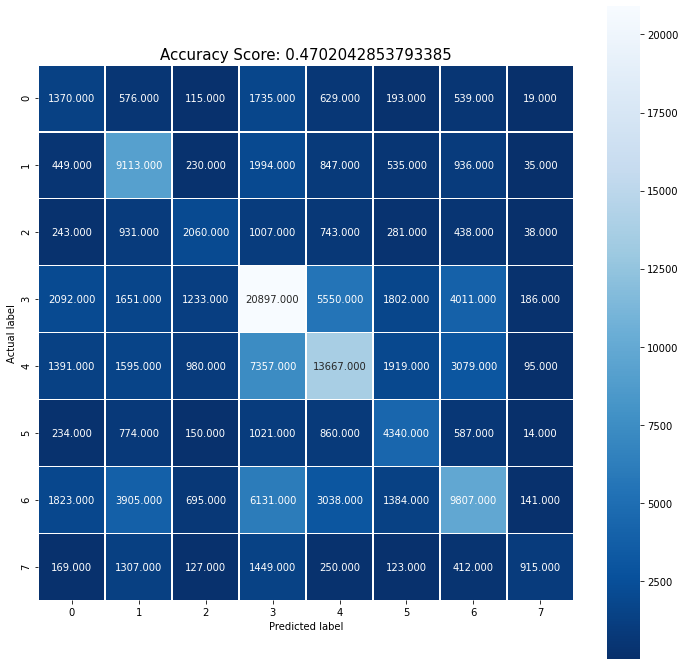

In [ ]:
cm = metrics.confusion_matrix(y_test, lscv_pip_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(lscv.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

#### Fine tuning
* We saw that the best *C* was between the highest and the lowest, so we will try to search around `0.5`.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.pipeline import make_pipeline
from sklearn import metrics


grid_values = { 'C' : [0.4, 0.5, 0.6],
                'penalty' : ['l1', 'l2'], 
                'tol' : [0.01, 0.1, 0.15]
              }

stra_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)


lscv_pip_2 = make_pipeline(HashingVectorizer(stop_words = all_stopwords2,
                                           tokenizer=spacy_tokenizer, ngram_range=(1,2), token_pattern=None),
                         TfidfTransformer(),
                         GridSearchCV(LinearSVC(random_state = 5, class_weight = class_weights),
                                                    param_grid = grid_values, n_jobs = -1, verbose = 3,
                                                    cv = stra_cv, scoring = 'f1_macro',
                                                    refit = True))

In [ ]:
%%time
lscv_pip_2.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.6min finished


CPU times: user 2min 18s, sys: 3.07 s, total: 2min 21s
Wall time: 6min 55s


Pipeline(steps=[('hashingvectorizer',
                 HashingVectorizer(ngram_range=(1, 2),
                                   stop_words=['τοσου', 'καμποσες', 'ολα',
                                               'ορισμενων', 'ορισμενα',
                                               'εκαστος', 'μελλεται', 'καθενος',
                                               'οταν', 'αλλοι', 'προχτες',
                                               'εξι', 'προχθες', 'οσων',
                                               'καθολου', 'εχομε', 'περι',
                                               'αλλιωτικα', 'καμποσης', 'γι',
                                               'εαυτους', 'τοσην', 'ποιος',
                                               'του', 'οποιου', 'ετερους',
                                               'ενα', 'λιγο', 'καμιας', 'κανεν', ...]...
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                              estimator=Linear

In [ ]:
lscv_pip_2[2].best_params_

{'C': 0.4, 'penalty': 'l2', 'tol': 0.1}

* Because our system crashed at this point, we will re-run the model.
* Thanks God, we printed the best parameteres.
____
* We will try to fine tune again but we know that the lower the C it gets, the more accurate our classifers gets.
* We will search for C between [0.2, 0.4].
* Also, we raise the k in **StratifiedKFold** to 10, to get the best view of our model.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.pipeline import make_pipeline
from sklearn import metrics

stra_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)


lscv_pip_last = make_pipeline(HashingVectorizer(stop_words = all_stopwords2,
                                           tokenizer=spacy_tokenizer, ngram_range=(1,2), token_pattern=None),
                         TfidfTransformer(),
                         GridSearchCV(LinearSVC(random_state = 5, class_weight = class_weights, penalty='l2', tol=0.1),
                                                    param_grid = {'C' : [0.2, 0.3, 0.4]},
                                                    n_jobs = -1, verbose = 3,
                                                    cv = stra_cv, scoring = 'f1_macro',
                                                    refit = True))

* We fit the model.

In [ ]:
%%time
lscv_pip_last.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:  1.2min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  2.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished


CPU times: user 2min 11s, sys: 2.53 s, total: 2min 13s
Wall time: 4min 49s


Pipeline(steps=[('hashingvectorizer',
                 HashingVectorizer(ngram_range=(1, 2),
                                   stop_words=['ωστε', 'καποιαν', 'το', 'ειχε',
                                               'τουτης', 'εισαστε', 'ολη',
                                               'ποιους', 'ναι', 'ακομα', 'εστω',
                                               'εγκαιρα', 'οποιωνδηποτε',
                                               'τοσος', 'ου', 'συχνως',
                                               'τετοιους', 'μελλεται', 'αμεσα',
                                               'συχνην', 'ειχαν', 'ταυτες',
                                               'οσον', 'ενω', 'ετουτης', 'μα',
                                               'μην', 'ολογυρα', 'εμενα',
                                               'οποιον', ...],
                                   token_patter...
                 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=5, shuffle=True),
         

In [ ]:
lscv_pip_last[2].best_params_

{'C': 0.3}

* So, the best `C = 0.3`.
* We didn't get really any better. Except of the minority class.

In [ ]:
lscv_pip_last_pred = lscv_pip_last.predict(X_test)
print(metrics.classification_report(y_test, lscv_pip_last_pred,
                                    target_names=leb.classes_))

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.18      0.28      0.22      5176
         ΚΚΕ       0.46      0.65      0.54     14139
        ΛΑΟΣ       0.35      0.38      0.36      5741
          ΝΔ       0.50      0.56      0.53     37422
       ΠΑΣΟΚ       0.55      0.45      0.49     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.40      0.56      0.47      7980
      ΣΥΡΙΖΑ       0.50      0.36      0.42     26924
        Χ.Α.       0.68      0.19      0.29      4752

    accuracy                           0.47    132217
   macro avg       0.45      0.43      0.42    132217
weighted avg       0.49      0.47      0.47    132217



#### Dealing with imbalanced data
* Another way to deal with the imbalanced data is by using SMOTE and RandomUnderSampler, as we did on *Naive Bayes*.

In [ ]:
np.bincount(y_train)

array([10226, 28372, 11522, 76130, 61096, 16484, 55190,  9420])

* We will hard code the **sampling strategy**. 
* We reduce the majorities and increase the minorites.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from imblearn.pipeline import Pipeline
from sklearn import metrics

over_dic = { 0: 15000, 1: 28372, 2: 15000, 3: 76130, 4: 61096, 5: 16484, 6: 55190, 7: 15000}
under_dic = { 0: 15000, 1: 20000, 2: 15000, 3: 30000, 4: 30000, 5: 16484, 6: 30000, 7: 15000}

#stra_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 5)

lscv_pip_imb = Pipeline([('vect', HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer,
                                                    ngram_range=(1,2), alternate_sign=False, token_pattern=None)),        
                     ('oversampling', SMOTE(sampling_strategy=over_dic, random_state = 5 )),
                     ('undersampling', RandomUnderSampler(sampling_strategy=under_dic, random_state = 5)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC(random_state = 5, penalty='l2', tol=0.1, C = 0.3)),
                    ], verbose = 2)

In [ ]:
%%time
lscv_pip_imb.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 5) Processing vect, total= 1.4min
[Pipeline] ...... (step 2 of 5) Processing oversampling, total=  10.6s
[Pipeline] ..... (step 3 of 5) Processing undersampling, total=   0.2s
[Pipeline] ............. (step 4 of 5) Processing tfidf, total=   5.2s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  15.6s
CPU times: user 1min 52s, sys: 3.29 s, total: 1min 55s
Wall time: 1min 55s


Pipeline(steps=[('vect',
                 HashingVectorizer(alternate_sign=False, ngram_range=(1, 2),
                                   stop_words=['ωστε', 'καποιαν', 'το', 'ειχε',
                                               'τουτης', 'εισαστε', 'ολη',
                                               'ποιους', 'ναι', 'ακομα', 'εστω',
                                               'εγκαιρα', 'οποιωνδηποτε',
                                               'τοσος', 'ου', 'συχνως',
                                               'τετοιους', 'μελλεται', 'αμεσα',
                                               'συχνην', 'ειχαν', 'ταυτες',
                                               'οσον', 'ενω', 'ετουτης', 'μα',
                                               'μην', 'ολογυρα', 'εμενα',
                                               'οποιον', ...],
                                   toke...
                                   tokenizer=<function spacy_tokenizer at 0x7f5f7d91a5f0>)),
        

* We see that the minority classes 

In [ ]:
lscv_pip_imb_pred = lscv_pip_imb.predict(X_test)
print(metrics.classification_report(y_test, lscv_pip_imb_pred,
                                    target_names=leb.classes_))

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.25      0.23      0.24      5176
         ΚΚΕ       0.50      0.57      0.53     14139
        ΛΑΟΣ       0.42      0.34      0.38      5741
          ΝΔ       0.55      0.46      0.50     37422
       ΠΑΣΟΚ       0.50      0.46      0.48     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.43      0.54      0.48      7980
      ΣΥΡΙΖΑ       0.39      0.47      0.43     26924
        Χ.Α.       0.30      0.34      0.32      4752

    accuracy                           0.46    132217
   macro avg       0.42      0.43      0.42    132217
weighted avg       0.47      0.46      0.46    132217



* Although accuracy is not really high `46 %`, we can see that the minority class *ΔΗ.ΣΥ* is also predicted as class *ΣΥΡΙΖΑ*. This isn't extremely wrong because those 2 are right-wing parties.

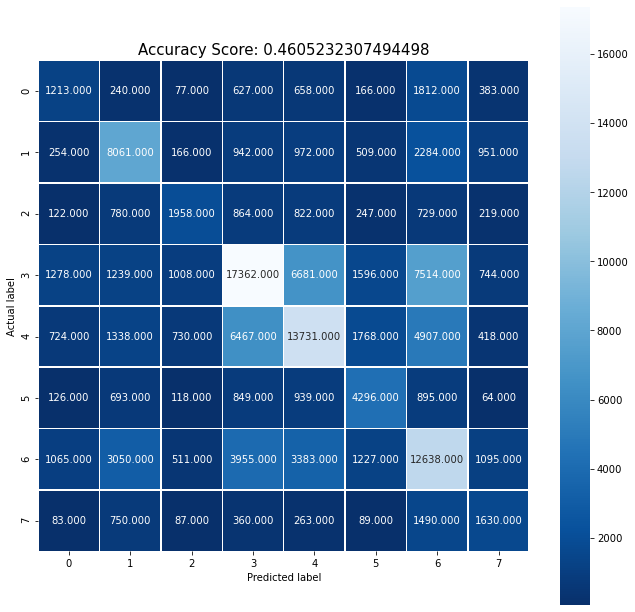

In [ ]:
cm = metrics.confusion_matrix(y_test, lscv_pip_imb_pred)

plt.figure(figsize=(11,11))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(lscv_pip_imb.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

#### Logistic Regression
* Another linear Classifier is the *sklearn's* **LogisticRegression**.
* We will make the same weights for each class, in order to reduce the imbalancement.

In [ ]:
class_weights = {}
total = len(y_train)
for i in range(0,8):

  population_i = np.bincount(y_train)[i]
  class_weights[i] = (1/population_i) * (total)/8
print(class_weights)

{0: 3.281341678075494, 1: 1.1826801071478923, 2: 2.9122548168720708, 3: 0.4407592276369368, 4: 0.5492176247217494, 5: 2.035610288764863, 6: 0.6079905780032615}


* We will apply *GridSearch*, to optimize the hyper-parameters.
* The paarameters that should be optimized are:
  * `C`: same as previous Classifiers.
  * `class_weight` : reduce imbalancement.
  * `penalty` : the norm used in the penalization.
  * `tol` : tolerance for stopping.
  * `solver` : there are many solvers we will try 4 of them.



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.pipeline import make_pipeline
from sklearn import metrics


grid_values = { 'C' : [0.1, 0.5, 1],
                'class_weight' : [ class_weights, None],
                'penalty' : ['l1', 'l2', 'esaticnet'], 
                'tol' : [1e-4, 0.1, 0.2],
                'solver' : ['lbfgs', 'liblinear', 'sag', 'saga']
              }

stra_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 5)

log_re = LogisticRegression(random_state = 5)


log_pip = make_pipeline(HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2)),
                         TfidfTransformer(),
                         GridSearchCV(log_re, param_grid = grid_values, n_jobs = -1,
                                      verbose = 3, cv = stra_cv, scoring = 'f1_macro', refit = True))

In [ ]:
%%time
log_pip.fit(X_train, y_train)

/srv/conda/envs/saturn/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed: 58.2min
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed: 82.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 150.0min finished


CPU times: user 1h 10min 38s, sys: 4min 25s, total: 1h 15min 3s
Wall time: 2h 40min 41s


Pipeline(steps=[('hashingvectorizer',
                 HashingVectorizer(ngram_range=(1, 2),
                                   stop_words=['οποιων', 'οσην', 'γρηγορα',
                                               'περι', 'αλλα', 'τελευταιος',
                                               'οι', 'εχει', 'ορισμενως',
                                               'οποιανδηποτε', 'μπορει',
                                               'μελλεται', 'υποψιν', 'συχνως',
                                               'δικου', 'τελικα', 'εστω',
                                               'μονη', 'ποση', 'υπερ', 'τοτε',
                                               'προ', 'δικο', 'εξι', 'αλλης',
                                               'οσης', 'που', 'αφοτου', 'μεσα',
                                               'οποια', ...],
                                   tokenizer=<fun...
                              estimator=LogisticRegression(random_state=5),
                          

* We get the hyper parameters:
  * `C = 1`
  * We should use the weights.
  * `penalty = l2`
  * Solver soulh be the liblinear
  * `tol = 0.0001`, very low

In [ ]:
log_pip[2].best_params_

{'C': 1,
 'class_weight': {0: 3.281341678075494,
  1: 1.1826801071478923,
  2: 2.9122548168720708,
  3: 0.4407592276369368,
  4: 0.5492176247217494,
  5: 2.035610288764863,
  6: 0.6079905780032615},
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 0.0001}

* We see that accuracy is around 47%, recall and F-1 score are a little bit lower.
* Also, we see that there is a problem with the minority classes.

In [ ]:
log_pip_pred = log_pip.predict(X_test)
print(metrics.classification_report(y_test, log_pip_pred,
                                    target_names=leb.classes_))

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.19      0.28      0.22      5176
         ΚΚΕ       0.48      0.63      0.54     14139
        ΛΑΟΣ       0.37      0.36      0.36      5741
          ΝΔ       0.48      0.58      0.53     37422
       ΠΑΣΟΚ       0.54      0.44      0.48     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.41      0.55      0.47      7980
      ΣΥΡΙΖΑ       0.49      0.35      0.41     26924
        Χ.Α.       0.80      0.13      0.22      4752

    accuracy                           0.47    132217
   macro avg       0.47      0.41      0.40    132217
weighted avg       0.49      0.47      0.46    132217



**Confusion Matrix**
It shows aht we have already discussed. Our models are good on predicting the major classes, but they are struggling to predict the minor classes.

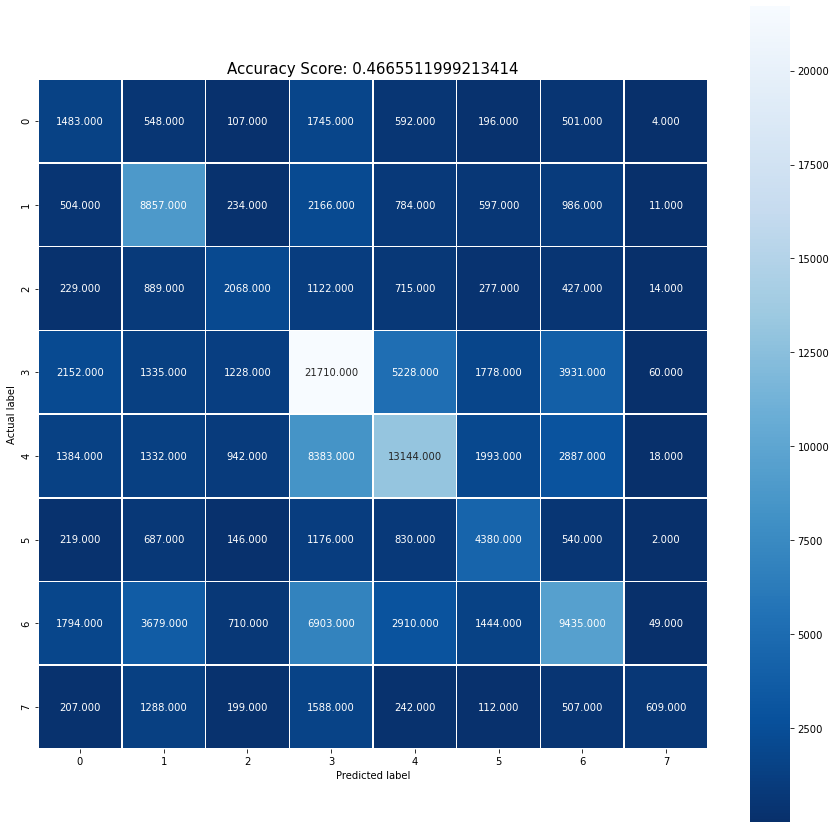

In [ ]:
cm = metrics.confusion_matrix(y_test, log_pip_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(log_pip.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

### Tree Approach
### Random Forest Classifier
* We can approach the problem with trees. 
* For this approach we will use the **Random Forest Classifier** from sklearn.
* We will use the default settings, 100 trees and bootstrap enabled.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression


greek_random = Pipeline([('vect', HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2), alternate_sign=False)),   
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=5, verbose=2, n_jobs=-1) )])

In [ ]:
%%time
greek_random.fit(X_train, y_train)

/srv/conda/envs/saturn/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed: 69.8min remaining:  9.5min


CPU times: user 1d 15h 4min 49s, sys: 15.3 s, total: 1d 15h 5min 5s
Wall time: 1h 24min 51s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 81.2min finished


Pipeline(steps=[('vect',
                 HashingVectorizer(alternate_sign=False, ngram_range=(1, 2),
                                   stop_words=['καποιους', 'εμεις', 'μελει',
                                               'τουτης', 'εσυ', 'ορισμενως',
                                               'καθενα', 'συγχρονως', 'ταυτος',
                                               'ο', 'εκει', 'ταυτων', 'εχω',
                                               'δικοι', 'επειδη', 'περισσοτερο',
                                               'ολωσδιολου', 'αμα', 'καμποση',
                                               'καθετι', 'οποιος', 'συχνην',
                                               'ταδε', 'εχει', 'πολλους',
                                               'μελλεται', 'σε', 'ετουτος',
                                               'μια', 'οσοι', ...],
                                   tokenizer=<function spacy_tokenizer at 0x7f4b70031830>)),
                ('tfidf', TfidfTransfor

In [ ]:
greek_random_pred = greek_random.predict(X_test)
print(metrics.classification_report(y_test, greek_random_pred,
                                    target_names=leb.classes_))

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:   12.7s remaining:    1.7s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   14.1s finished


              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.18      0.01      0.02      5176
         ΚΚΕ       0.46      0.50      0.48     14139
        ΛΑΟΣ       0.51      0.06      0.11      5741
          ΝΔ       0.38      0.68      0.49     37422
       ΠΑΣΟΚ       0.39      0.35      0.37     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.38      0.08      0.13      7980
      ΣΥΡΙΖΑ       0.32      0.24      0.28     26924
        Χ.Α.       0.56      0.06      0.10      4752

    accuracy                           0.39    132217
   macro avg       0.40      0.25      0.25    132217
weighted avg       0.38      0.39      0.35    132217



* The results are not really encouraging. 
* The accuracy is around 39% and precision, recall and F-1 score are really low.
* **We also print the confusion matrix to have a better view on our model.**
* We see that the problem may be the imbalancement that our data have.


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:   12.6s remaining:    1.7s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   14.2s finished


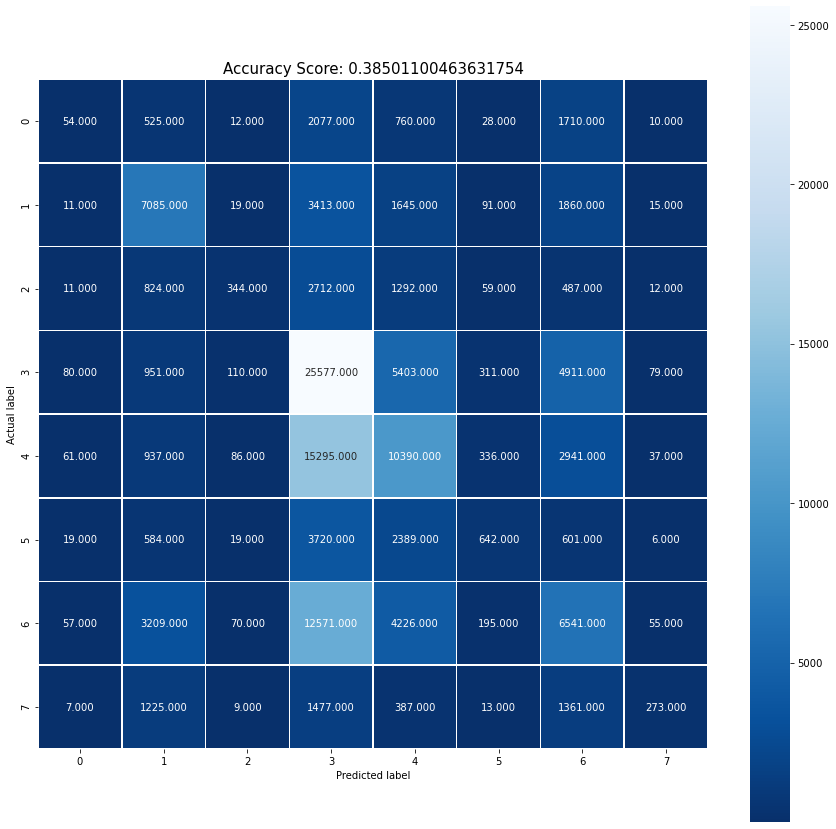

In [ ]:
cm = metrics.confusion_matrix(y_test, greek_random_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(greek_random.score(X_test,y_test))
plt.title(all_sample_title, size = 15);

#### XGBClassifier Tree

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer


over_sampleer = { 0: 15000, 1: 28372 , 2: 16000, 3: 76130, 4: 61096, 5: 20000, 6: 55190, 7: 15000}
under_sampler = { 0: 15000, 1: 22000 , 2: 16000, 3: 25000, 4: 25000, 5: 20000, 6: 25000, 7: 15000}

imb_pip = Pipeline([('hash' , HashingVectorizer(stop_words = all_stopwords2, tokenizer=spacy_tokenizer, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()), 
                    ('oversampling', SMOTE(sampling_strategy=over_sampler)),
                    ('undersampling', RandomUnderSampler(sampling_strategy=under_sampler))                
])

smote_train, smote_labels = imb_pip(X_train, y_train)
X_train.shape, smote_train.shape

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import  XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics


grid_values = { 'eta' : [0.01, 0.2],
                'max_depth' : [5,8, 10],
              }


model_t = XGBClassifier(objective='multi:softmax', random_state = 5, eval_metric=['auc', 'merror'], subsample=0.5)

xgbc_pip_t = GridSearchCV(model_t, param_grid = grid_values, n_jobs= -1, verbose = 2, scoring='f1_macro', refit=True)

In [ ]:
%%time
xgbc_pip_t.fit(smote_train, smote_labels)  

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[03:26:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:26:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:26:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:26:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[03:27:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[03:27:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:27:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:27:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nod

Pipeline(memory=None,
         steps=[('vect',
                 HashingVectorizer(alternate_sign=False, analyzer='word',
                                   binary=False, decode_error='strict',
                                   dtype=<class 'numpy.float64'>,
                                   encoding='utf-8', input='content',
                                   lowercase=True, n_features=1048576,
                                   ngram_range=(1, 2), norm='l2',
                                   preprocessor=None,
                                   stop_words=['αυτος', 'εσας', 'περι', 'ποιας',
                                               'ιδιοσ', 'αρα', 'καποιον',
                                               'κατοπιν', 'εκειν...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1, gamma=0,
                               learning_rate=0.1, m

In [ ]:
X_test_vect = imb_pip['hash'].fit_transform(X_test)
X_test_vect = imb_pip['tfidf'].fit_tranform(X_test_vect)

In [ ]:
xgbc_pip_t_pred = xgbc_pip_t.predict(X_test_vect)
print(metrics.classification_report(y_test, xgbc_pip_t_pred,
                                    target_names=leb.classes_))

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.78      0.04      0.08      5176
         ΚΚΕ       0.51      0.45      0.48     14139
        ΛΑΟΣ       0.83      0.10      0.18      5741
          ΝΔ       0.35      0.88      0.50     37422
       ΠΑΣΟΚ       0.45      0.23      0.31     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.78      0.19      0.30      7980
      ΣΥΡΙΖΑ       0.49      0.13      0.20     26924
        Χ.Α.       0.80      0.14      0.23      4752

    accuracy                           0.40    132217
   macro avg       0.62      0.27      0.29    132217
weighted avg       0.50      0.40      0.34    132217



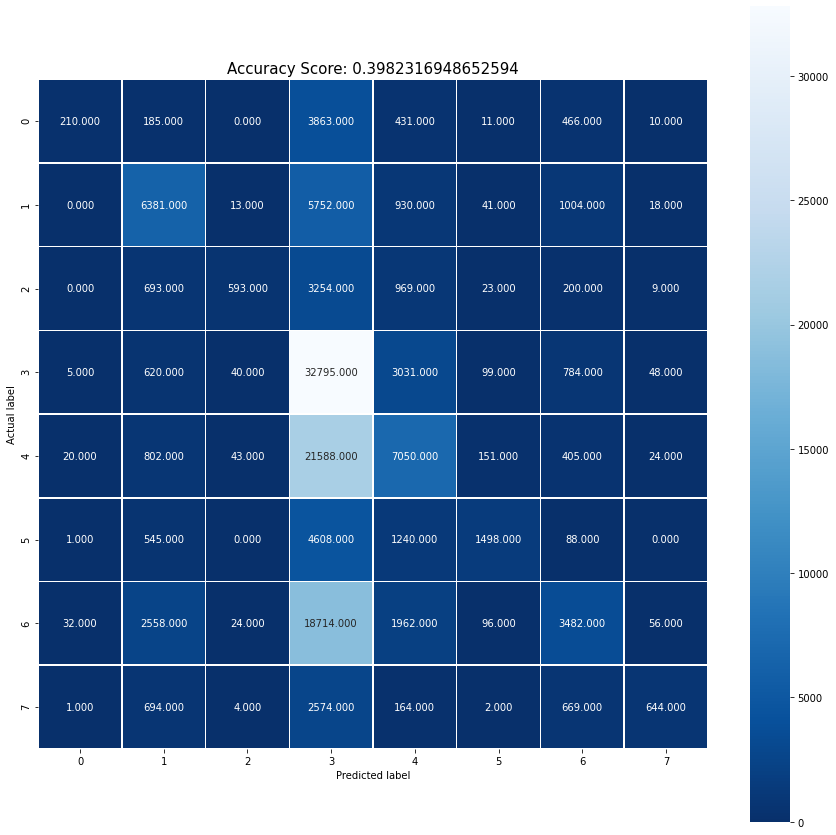

In [ ]:
cm = metrics.confusion_matrix(y_test, xgbc_pip_t_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(xgbc_pip_t.score(X_test_vect, y_test))
plt.title(all_sample_title, size = 15);

# Neural Networks
<a id="nnclass"></a>

* We will use the CNN architecture.
* The first model we will produce is a basic CNN with one input and one 1D Convolutional layer.
* The second approch is a multi-channel CNN which takes the same input but each Convolutional layer being processed separately.

**Results**
___
| Model     | Accuracy | Precision (macro) | Recall (macro) | F-1 score (macro)
| ----------- | ----------- | ----------- | ----------- | ----------- |
|---|----|(macro)|(macro)|(macro)|
| One-Conv      | **41%**      |**55%** |**28%**|**31%**
| Multi-Channel CNN    | 26%        |30%| 31%|25%|

As we can see the best Model was the single channel Convolutional NN with 41% accuracy and 31% F-1 score.






## Preprocessing
* Before creating our model, we need to preprocess our data, to feed them to the model.
* We use the `Counter` function to find the frequence for each word in our speeches.

In [35]:
from collections import Counter

def counter_word(text):
  count = Counter()
  for i in text:
    for word in i.split():
      count[word]+=1
  return count

text = greek_df_cl.speech.values

counter = counter_word(text)
len(counter)

293936

* After finding the number of words, we assign it to a variable called `num_words`. 
* We will use this variable to create our Tokenizer.
* Also, we create another variable `max_length`. We need it for Neural Network to pre determine the max length of each sentence.
* We choose the `max_length = 200` because we show on [Avg. Words per PP](#words) on average each speaker in political party has a speech of 150-200 words.

In [36]:
num_words = len(counter)
max_length = 200

* For Tokenization, we will use the **Tokenizer** API from *keras*.
* We will pas as number of words, the variable we created.
* Also, we will create a new variable called `word_index`, which holds an index for each word in our speeches.

In [37]:
import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

* Next, we create a sequence for each speech.
* **Sequence** will help us to create stenences with same length.
* For example, we print the first sentce, which give us a list with 6 numbers, those 6 numbers are *indexes* and each points to a specific word.

In [38]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq[0]

[3, 2844, 10, 368, 31, 530]

* Moving next, we will pad the sequences. 
* So, what we do is to strip all sentences on the same length. The length will be **200** words. 
* We leave the default parameteres `truncating, padding = 'pre' `. This means that after 200 words, the pas_sequences will strip the first words. The reason we do this, is based on the article of [Dwarampudi M. R. and N V Subba Reddy](https://arxiv.org/pdf/1903.07288.pdf), which expalins that the major point of someone's speech is more posssible be in the middle and at the end of his speech.
* The number **200** comes from the max_legth variable, we had assigned.
* So we print the first sequence*(speech)*. The first speech has 6 words as we show and the rest 196 words are zeros.

In [39]:
from keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

* We do the same for **test** dataset. The only diffrence is that we use the same *tokenizer*, which means that some words are gonna be ingored.

In [40]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

* Let's validate are *Tokenizer*.

In [41]:
print('The first speech is: ' , X_train[0])
print('The word indexes for the first speech based on the tokenizer are: ' , X_train_seq[0])

The first speech is:  να τελειωσω ειναι δυνατον σας παρακαλω
The word indexes for the first speech based on the tokenizer are:  [3, 2844, 10, 368, 31, 530]


* We reverse the tokenizer through a function, which takes the keys and the values of the **word_index**, and joinning the words.
* We see that the first sequence from the Tokenizer matches the first speech of our dataset.

In [42]:
reverse_word_index = dict( [ (value,key) for (key,value) in word_index.items() ])

def decoder(text):
    
    return " ".join( [reverse_word_index.get(i, " ") for i in text])

print('The first sentence based to the tokenizer can be decoded as: ', decoder(X_train_seq[0]))

The first sentence based to the tokenizer can be decoded as:  να τελειωσω ειναι δυνατον σας παρακαλω


In [43]:
print( 'The shape of the training data set is: ', X_train_pad.shape)
print('The shape of the testing dataset is: ', X_test_pad.shape)

The shape of the training data set is:  (268440, 200)
The shape of the testing dataset is:  (132217, 200)


* Another thing we have to do, is to create dummies for its class.

In [44]:
from keras.utils import np_utils

y_train_t = np_utils.to_categorical(y_train)
y_test_t = np_utils.to_categorical(y_test)

print( 'The shape for the training labels is: ', y_train_t.shape)
print()
print( 'The shape for the testing labels is: ', y_train_t.shape)

The shape for the training labels is:  (268440, 8)

The shape for the testing labels is:  (268440, 8)


* We define a function which prints the evolution of the different metrics during the training for the training and the calidation trainings.
* Finally, we create a function in order to create a confusion matrix and one for the classification report in order to evaluate the model, with the testing data.

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_metrics(history, color):
    metrics = ['loss', 'categorical_accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        
        plt.subplot(1,2,n+1)
        plt.title(name)
        plt.plot(history.epoch, history.history[metric], color=color, label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=color, linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        
        plt.legend()

def conf_m(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(11,11))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Confusion Matrix', size = 15);

def class_re(y_true, y_pred, labels):
    return print(classification_report(y_true, y_pred, target_names=labels))

## Models
* We will train our Neural Networks on Google's Colab TPUs.
* We will use the same code as in [Google's Colab TPU Notebook](https://colab.research.google.com/notebooks/tpu.ipynb), to initialize the TPUs.
* You can remove the hashtags to run it in TPU.

In [ ]:
#%tensorflow_version 2.x
#import tensorflow as tf
#print("Tensorflow version " + tf.__version__)
#tf.keras.backend.clear_session()
#
#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
#
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

#### **Basic CNN**
* First, we are gonna make a very basic CNN. 
* The first layer is an `Embedding Layer`, which will find 256 different dimensions for each word in the voc. The number of the embedding dimensions is a pesudo-random number. Maybe, we will need to tune this parameter.
---
 **Layers**
* The next Layer is an *One-Dim Convolutional* with *64* filters and *3 kernel_size (could be considered as a 3-grams).
* Moving next, we dropout the *70%* of our neurons, in order to reduce overfitting .
* Next, we have a *MaxPooling* layer which takes the max out of a region of 10.
* Lastly, we Flatten the neurons and we take the output, which is 8 probabilities one for each class.
---
**Metrics**
* The NN will calculate for each epoch the: [*Categorical Accuracy*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy), which calculates how often predictions matches one-hot labels.
---
**Compilation**
* As an optimizer we use the default **Adam** optimizer. 
* As loss function, we will use the **CategoricalCrossentropy**, which we take care entropy for the 8 different classes. Also, we enable *from_logits*, which means that the function will push the probabilities to 0. We are doing this in order to reduce overfitting again.



In [55]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

keras.backend.clear_session() #cleaning the session

EMBEDDING_DIM = 256

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = Adam()

def make_model():

    model = Sequential()

    model.add(Embedding( num_words, EMBEDDING_DIM, input_length=max_length))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train_pad.shape))
  
    model.add(Dropout(0.7))
    model.add(MaxPooling1D(5))

    model.add(Flatten())
    model.add(Dense(8, activation='softmax'))

    model.compile(loss = loss, optimizer = optimizer, metrics = tf.keras.metrics.CategoricalAccuracy())    
    return model

# You may want to remove the hashtags in order to run the model on Google's Colab TPU. Don't forget to put hashtag on the next line.
#with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#
#    model = make_model()

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 256)          75247616  
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 64)           49216     
_________________________________________________________________
dropout (Dropout)            (None, 198, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2496)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 19976     
Total params: 75,316,808
Trainable params: 75,316,808
Non-trainable params: 0
____________________________________________

* We choose *20* epochs and batch_size=64 multiplied by the number of the TPUs in Google Colab (8).
* Also, we use the *10%* of the training data as a *validation* set. We use the validation set to enable **EarlyStopping**, which based on the validation loss, it will stop the training if there is no improvement for 5 epochs in a row and it will get the best weights.

In [56]:
epochs = 20
batch_size = 64 #* tpu_strategy.num_replicas_in_sync #If you want the model to run o the 8-core TPU, you can remove the hashtag. Otherwise the optomal batch_size is the 64*8

history = model.fit( X_train_pad, y_train_t, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], shuffle=True)

Epoch 1/20
420/420 [==============================] - 29s 55ms/step - loss: 1.7745 - categorical_accuracy: 0.2862 - val_loss: 1.6751 - val_categorical_accuracy: 0.3582
Epoch 2/20
420/420 [==============================] - 17s 41ms/step - loss: 1.4926 - categorical_accuracy: 0.4148 - val_loss: 1.5801 - val_categorical_accuracy: 0.4025
Epoch 3/20
420/420 [==============================] - 17s 41ms/step - loss: 1.2820 - categorical_accuracy: 0.5024 - val_loss: 1.5480 - val_categorical_accuracy: 0.4093
Epoch 4/20
420/420 [==============================] - 18s 42ms/step - loss: 1.1609 - categorical_accuracy: 0.5476 - val_loss: 1.5661 - val_categorical_accuracy: 0.4005
Epoch 5/20
420/420 [==============================] - 17s 41ms/step - loss: 1.0806 - categorical_accuracy: 0.5759 - val_loss: 1.5993 - val_categorical_accuracy: 0.3987
Epoch 6/20
420/420 [==============================] - 17s 42ms/step - loss: 1.0353 - categorical_accuracy: 0.5924 - val_loss: 1.6441 - val_categorical_accuracy:

* We print the losses (training and validation) and the categorical accuracy (training and valdiation)
* We see that our model is very small and it begins to overfit during 1-2 epochs.

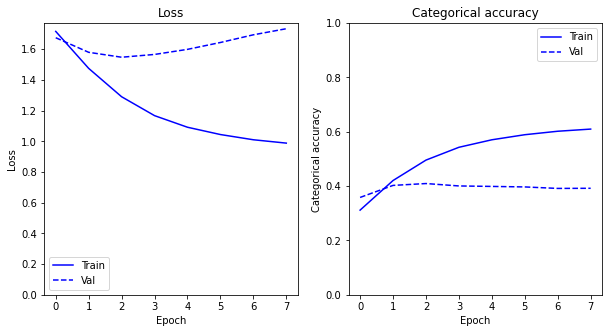

In [57]:
histories[0] = history

plt.figure(figsize=(10, 5))
plot_metrics(history, 'blue')

* Evaluating the test dataset.
* We get 37% accuracy but the loss is too high.

In [58]:
accr = model.evaluate( X_test_pad, y_test_t)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4132/4132 [==============================] - 59s 14ms/step - loss: 1.5496 - categorical_accuracy: 0.4063
Test set
  Loss: 1.550
  Accuracy: 0.406


**Printing the *Classification report* and the *Confusion Matrix***
* Although, accuracy is around 41%, the rest metrics are lower.
* We can see that some classes are not predicted at all. This is due to the imbalancementof our dataset.

In [59]:
test_predictions_baseline = model.predict(X_test_pad, batch_size=batch_size)
testings[0] = test_predictions_baseline

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.49      0.02      0.03      5176
         ΚΚΕ       0.73      0.20      0.31     14139
        ΛΑΟΣ       0.53      0.17      0.26      5741
          ΝΔ       0.45      0.53      0.48     37422
       ΠΑΣΟΚ       0.40      0.46      0.43     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.70      0.29      0.41      7980
      ΣΥΡΙΖΑ       0.31      0.51      0.38     26924
        Χ.Α.       0.79      0.09      0.16      4752

    accuracy                           0.41    132217
   macro avg       0.55      0.28      0.31    132217
weighted avg       0.47      0.41      0.39    132217



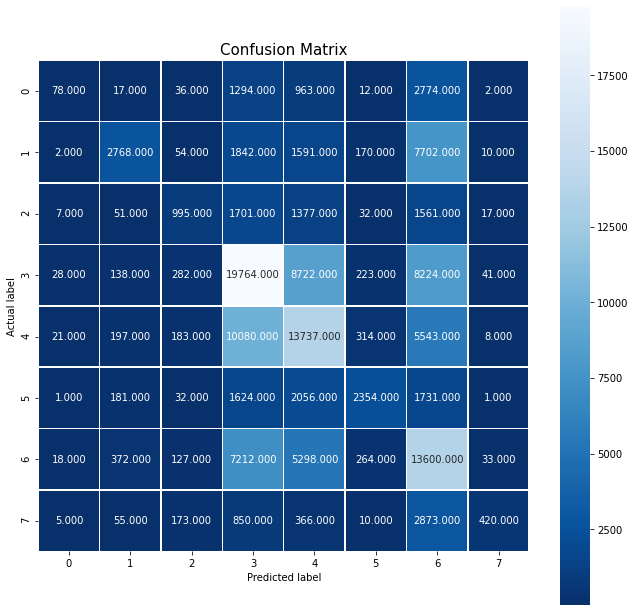

In [60]:
rep = class_re(y_test, np.argmax(test_predictions_baseline, axis=1), leb.classes_)
mat = conf_m(y_test, np.argmax(test_predictions_baseline, axis=1) )

#### **Multi-channel CNN**
* Another approach we can follow is to create several channels for inputs. After a lot of tries, we think that the 2 channels are more than enough.
* The architecture for this model tries to mimic the 1-gram and 2-grams approach.
* There are 2 sets of Convolutional architect Conv1D-Pool-Dropout). The first finds the 1-grams and the second the 2-grams.
____
* We saw on the basic CNN that we have to deal with 2 very common enemies. Over-fitting and Imbalancement.
* We will use `l2` regularizer with a small penalty at 0.0005.
* Also, to deal with the overfitting we are enabling a Learning Rate Scheduler. The scheduler will reduce the learning rate by 50% for each 10 epochs.

___
* The optimizer we will use is the *Adamax* because based on Tensorflow, it's more effieccient for models with Embeddings.



In [124]:
from keras.models import Model
import tensorflow as tf
from tensorflow.python.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input, Activation
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers
from keras.optimizers import Adamax
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
import math

keras.backend.clear_session() #cleaning the session

initial_learning_rate = 0.01
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 5.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

EMBEDDING_DIM = 256

batch_size = 128 #* tpu_strategy.num_replicas_in_sync #If you want the model to run o the 8-core TPU, you can remove the hashtag. Otherwise the optomal batch_size is the 128*8
epochs = 50

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

optimizer = Adamax()

def make_model():

    input = Input(shape=(max_length,))
    embedding = Embedding( num_words, EMBEDDING_DIM, input_length=max_length)(input)

    conv1 = Conv1D(filters=16, kernel_size=3, kernel_regularizer=regularizers.l2(0.0005))(embedding)
    act1 = Activation(activation='relu')(conv1)
    pool1 = MaxPooling1D(5)(act1)
    drop1 = Dropout(0.5)(pool1)
    flat1 = Flatten()(drop1)

    conv2 = Conv1D(filters=16, kernel_size=2, kernel_regularizer=regularizers.l2(0.0005))(embedding)
    act2 = Activation(activation='relu')(conv2)
    pool2 = MaxPooling1D(20)(act2)
    drop2 = Dropout(0.5)(pool2)
    flat2 = Flatten()(drop2)

    conv3 = Conv1D(filters=16, kernel_size=1, kernel_regularizer=regularizers.l2(0.0005))(embedding)
    act3 = Activation(activation='relu')(conv3)
    pool3 = MaxPooling1D(30)(act3)
    drop3 = Dropout(0.5)(pool3)
    flat3 = Flatten()(drop3)

    merged = concatenate([ flat1, flat2, flat3])

    dropout = Dropout(0.7)(merged)

    outputs = Dense(8, activation='softmax')(dropout)

    model = Model(inputs=input, outputs=outputs)

    model.compile(loss = loss, optimizer = optimizer, metrics = tf.keras.metrics.CategoricalAccuracy())    
    plot_model(model, show_shapes=True)
    return model

# You may want to remove the hashtags in order to run the model on Google's Colab TPU. Don't forget to put hashtag on the next line.
#with tpu_strategy.scope(): 

#    model = make_model()

model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 256)     75247616    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 198, 16)      12304       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 199, 16)      8208        embedding[0][0]                  
______________________________________________________________________________________________

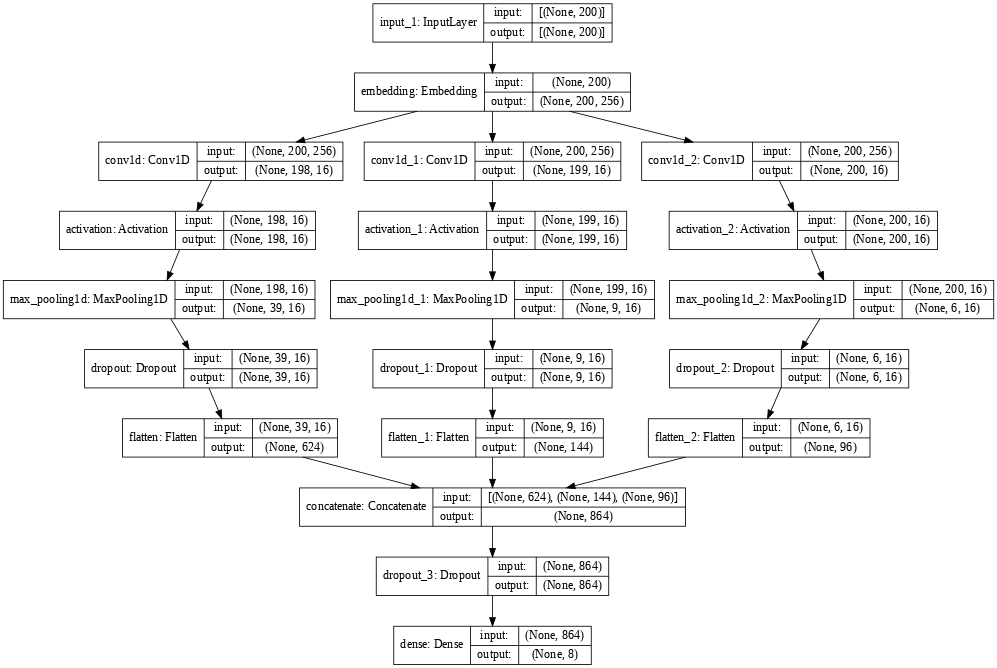

In [125]:
plt.figure
plot_model(model, show_shapes=True, dpi=60)

In [126]:
class_weights = {}
total = len(y_train)
for i in range(0,8):

  population_i = np.bincount(y_train)[i]
  class_weights[i] = (1/population_i) * (total)/8
print(class_weights)


history = model.fit(X_train_pad, y_train_t, epochs=epochs, batch_size=batch_size, validation_split=0.2, class_weight=class_weights,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True), LearningRateScheduler(lr_step_decay, verbose=1)],
                    shuffle=True)

{0: 3.281341678075494, 1: 1.1826801071478923, 2: 2.9122548168720708, 3: 0.4407592276369368, 4: 0.5492176247217494, 5: 2.035610288764863, 6: 0.6079905780032615, 7: 3.5621019108280256}
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
210/210 [==============================] - 24s 80ms/step - loss: 2.0830 - categorical_accuracy: 0.1538 - val_loss: 1.9832 - val_categorical_accuracy: 0.1638
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
210/210 [==============================] - 10s 46ms/step - loss: 1.9663 - categorical_accuracy: 0.1740 - val_loss: 1.8806 - val_categorical_accuracy: 0.2142
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
210/210 [==============================] - 10s 46ms/step - loss: 1.8865 - categorical_accuracy: 0.1825 - val_loss: 1.8671 - val_categorical_accuracy: 0.2157
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
210/210 [=====================

* We suceed to deal with the overfitting but the Accuracy was decreased a lot.

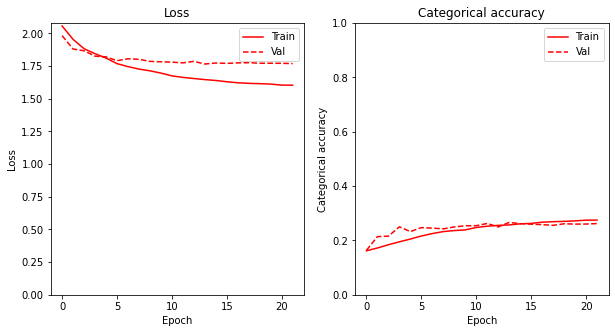

In [127]:
histories[1] = history

plt.figure(figsize=(10, 5))
plot_metrics(history, 'red')

In [128]:
accr = model.evaluate( X_test_pad, y_test_t)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4132/4132 [==============================] - 59s 14ms/step - loss: 1.7643 - categorical_accuracy: 0.2632
Test set
  Loss: 1.764
  Accuracy: 0.263


In [129]:
test_predictions_baseline = model.predict(X_test_pad, batch_size=batch_size)
testings[1] = test_predictions_baseline

* Although the accuracy is not that high at 26%, this model could handle the imbalancement a little bit better than the previous model.

              precision    recall  f1-score   support

       ΔΗ.ΣΥ       0.06      0.17      0.09      5176
         ΚΚΕ       0.52      0.18      0.26     14139
        ΛΑΟΣ       0.21      0.28      0.24      5741
          ΝΔ       0.47      0.27      0.34     37422
       ΠΑΣΟΚ       0.38      0.21      0.27     30083
 ΣΥΝΑΣΠΙΣΜΟΣ       0.36      0.44      0.40      7980
      ΣΥΡΙΖΑ       0.30      0.26      0.27     26924
        Χ.Α.       0.09      0.68      0.16      4752

    accuracy                           0.26    132217
   macro avg       0.30      0.31      0.25    132217
weighted avg       0.37      0.26      0.28    132217



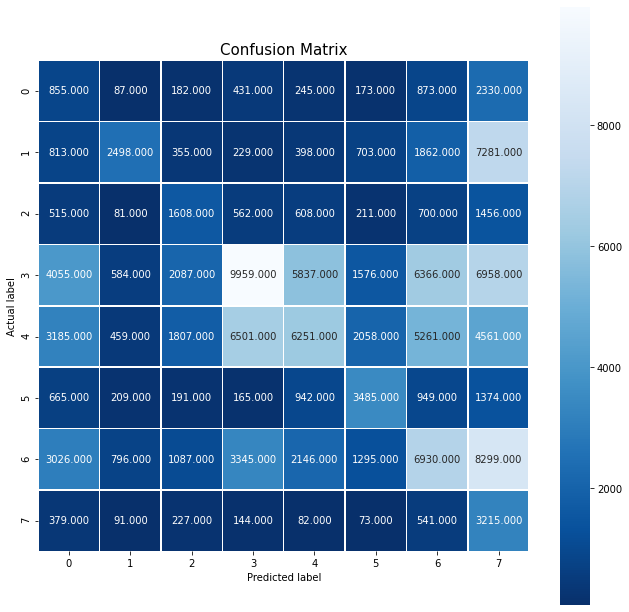

In [130]:
rep = class_re(y_test, np.argmax(test_predictions_baseline, axis=1), leb.classes_)
mat = conf_m(y_test, np.argmax(test_predictions_baseline, axis=1) )